# Importing packages

In [825]:
import os
import io
import json
import math
import folium
import zipfile
import shapely
import sklearn
import openpyxl
import requests
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import branca.colormap as cm
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point
from folium.plugins import HeatMap
from branca.colormap import linear
from pandas_ods_reader import read_ods
from folium.plugins import FastMarkerCluster
from shapely.geometry.polygon import Polygon
from folium.plugins import TimeSliderChoropleth
from sklearn.linear_model import LinearRegression
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Define recursive functions

In [2]:
def download_from_url(file_url,filepath):
    req = requests.get(file_url)
    with open(filepath, 'wb') as file:
        file.write(req.content)
    
    
def download_zip_url(file_url,filedest):
    req = requests.get(file_url)
    zipped = zipfile.ZipFile(io.BytesIO(req.content))
    zipped.extractall(filedest)
    
def private_or_public_charging(private_devices,electric_cars):
     if private_devices >= electric_cars: 
        return 'Predomintantly private'
     else: 
        return 'Predomintantly public'
    
def plot_postcode_district(df_nhb, la_val):
    
    dataframe = df_nhb[df_nhb.index.isin(dic_la[dic_name[la_val]])]
    
    print('Missing {num} Postcode Districts out of {la_len} ({per:.2f}% of the data)'.format(num = len(dic_la[dic_name[la_val]]) - len(dataframe), 
                                                                                        la_len = len(dic_la[dic_name[la_val]]),  
                                                                                        per = 100-(len(dataframe)/len(dic_la[dic_name[la_val]]))*100))
    
    for i in range(2,len(dataframe)+1):
        if len(dataframe)%i == 0:
            n_col = i
            break
    if n_col == len(dataframe):
        n_row = int((n_col-1)/4)
        n_col = math.ceil(len(dataframe) / n_row)
    else:
        n_row = math.ceil(len(dataframe)/n_col)
        
    fig, ax = plt.subplots(n_row,n_col,figsize=(30,25),dpi=300)
    idx_1=0
    idx_2=0


    ymax = round(dataframe.max().max()/10)*10

    for nhb_val in sorted(dataframe.index):
        if idx_2 ==n_col:
            idx_1 +=1
            idx_2 = 0

        nhb_sel = dataframe.loc[nhb_val].reindex(index=dataframe.loc[nhb_val].index[::-1])
        x = np.arange(len(nhb_sel.index))
        width = 0.7


        ax[idx_1,idx_2].bar(nhb_sel.index,nhb_sel,width) 
        ax[idx_1,idx_2].set_title('BEVs uptake in '+nhb_val)
        idx_2+=1

    while(idx_2<n_col):
        fig.delaxes(ax[idx_1,idx_2])
        idx_2+=1

    for ax in ax.flat:
        ax.label_outer()
        ax.set_ylim(0,ymax)
        ax.set_xlim(0,len(x))

        ax.set_xticks(x)
        ax.set_xticklabels(nhb_sel.index, rotation = 90, fontsize = 13 )
        ax.set_ylabel('Number of BEVs')


    fig.suptitle('BEVs uptake in '+la_val, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(la_val+'.png', bbox_inches='tight', dpi = 300)
    
    
def plot_postcode_district_percentage(df_nhb, la_val):
    
    dataframe = df_nhb[df_nhb.index.isin(dic_la[dic_name[la_val]])]
    
    print('Missing {num} Postcode Districts out of {la_len} ({per:.2f}% of the data)'.format(num = len(dic_la[dic_name[la_val]]) - len(dataframe), 
                                                                                        la_len = len(dic_la[dic_name[la_val]]),  
                                                                                        per = 100-(len(dataframe)/len(dic_la[dic_name[la_val]]))*100))
    
    for i in range(2,len(dataframe)+1):
        if len(dataframe)%i == 0:
            n_col = i
            break
    if n_col == len(dataframe):
        n_row = int((n_col-1)/4)
        n_col = math.ceil(len(dataframe) / n_row)
    else:
        n_row = math.ceil(len(dataframe)/n_col)
        
    fig, ax = plt.subplots(n_row,n_col,figsize=(30,25))
    idx_1=0
    idx_2=0


    ymax = math.ceil(dft_ratio[dft_ratio.index.isin(dic_la[dic_name[west_yorkshire[4]]])].max().max())

    for nhb_val in sorted(dataframe.index):
        if idx_2 ==n_col:
            idx_1 +=1
            idx_2 = 0

        nhb_sel = dataframe.loc[nhb_val]
        x = np.arange(len(nhb_sel.index))
        width = 0.7


        ax[idx_1,idx_2].bar(nhb_sel.index,nhb_sel,width) 
        ax[idx_1,idx_2].set_title('BEVs uptake in '+nhb_val)
        idx_2+=1

    while(idx_2<n_col):
        fig.delaxes(ax[idx_1,idx_2])
        idx_2+=1

    for ax in ax.flat:
        ax.label_outer()
        ax.set_ylim(0,ymax)
        ax.set_xlim(0,len(x))

        ax.set_xticks(x)
        ax.set_xticklabels(nhb_sel.index, rotation = 90, fontsize = 13 )
        ax.set_ylabel('BEVs/total cars (%)')


    fig.suptitle('BEVs uptake in '+la_val, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(la_val+'_percentage.png', bbox_inches='tight', dpi = 300)

# Import files

In [3]:
dirname = 'Data'

In [4]:
if os.path.basename(os.getcwd())== 'local_authority_charging':
    if not os.path.isdir(dirname):
        try:
            os.mkdir(dirname)
        except OSError:
            print ("Creation of the directory %s failed" % dirname)
        else:
            print ("Successfully created the directory %s " % dirname)
    else: 
        print ("Directory %s already exists" % dirname)

Directory Data already exists


## Downloading the required datasets for the analysis 

In [5]:
#Linking the required datasets with the URLs to download them from 

required_files = {'EIR_E0019012.xlsx':'https://storage.googleapis.com/na_evhs/EIR_E0019012.xlsx',
                 'electric-vehicle-charging-device-statistics-october-2020.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/933589/electric-vehicle-charging-device-statistics-october-2020.ods',
                 'veh0132.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942248/veh0132.ods',
                 'veh0134.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942250/veh0134.ods',
                 'veh0122.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/942242/veh0122.ods',
                  'tra8901.ods':'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/925275/tra8901.ods',
                  'postcodes_active.csv':'',
                  'IMD_postcode.csv':''
                 }

In [6]:
# If not already present inside "Data" folder, download the required datasets and
# check the last time the datasets where downloaded/modified

for filename in required_files.keys():
    
    file_path = dirname+'/'+filename
    
    if os.path.isfile(file_path):
        print ("File %s already exists" % filename)
    else:
        download_from_url(required_files[filename],file_path)
        print ("Successfully downloaded the file %s " % filename)
    
    try:
        mtime = os.path.getmtime(file_path)
    except OSError:
        mtime = 0
    last_modified_date = datetime.fromtimestamp(mtime)
    
    print('    Last modified '+last_modified_date.strftime("%d/%m/%Y %H:%M:%S"))

File EIR_E0019012.xlsx already exists
    Last modified 12/01/2021 09:58:11
File electric-vehicle-charging-device-statistics-october-2020.ods already exists
    Last modified 12/01/2021 09:58:11
File veh0132.ods already exists
    Last modified 12/01/2021 09:59:28
File veh0134.ods already exists
    Last modified 12/01/2021 09:59:28
File veh0122.ods already exists
    Last modified 08/01/2021 10:50:22
File tra8901.ods already exists
    Last modified 15/01/2021 13:41:38
File postcodes_active.csv already exists
    Last modified 20/01/2021 16:00:36
File IMD_postcode.csv already exists
    Last modified 25/01/2021 13:35:39


In [7]:
#For file containing multiple sheets (e.g. Excel spreadsheet files) determine the number and the name of each sheet

for filename in os.listdir(dirname):
    
    file_path = dirname+'/'+filename
    
    if filename.endswith('.ods') or filename.endswith('.xls'):
        
        file_preview = pd.ExcelFile(file_path, engine ='odf')
        sheets_number = [sheet for sheet in file_preview.sheet_names if not sheet.startswith("'")]
        print('{} has {} sheet(s): {}'.format(filename,len(sheets_number),sheets_number))
        
    elif filename.endswith('.xlsx'):
        
        file_preview = openpyxl.load_workbook(file_path) 
        sheets_number = [sheet for sheet in file_preview.sheetnames if not sheet.startswith("'")]
        print('{} has {} sheet(s): {}'.format(filename,len(sheets_number),sheets_number))
    
    

EIR_E0019012.xlsx has 1 sheet(s): ['bypostcodedistrict']
electric-vehicle-charging-device-statistics-october-2020.ods has 3 sheet(s): ['Info', 'EVCD_01', 'EVCD_02']
tra8901.ods has 1 sheet(s): ['TRA8901']
veh0122.ods has 11 sheet(s): ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']
veh0132.ods has 4 sheet(s): ['VEH0132a', 'VEH0132b', 'VEH0132c', 'VEH0132d']
veh0134.ods has 3 sheet(s): ['VEH0134a', 'VEH0134b', 'VEH0134c']


# Import Postcode data

In [8]:
#Import file containing the information about, among others, postcodes, local authority
postcode_active = pd.read_csv(dirname+'/postcodes_active.csv',low_memory=False) 

In [9]:
postcode_active.columns

Index(['pcd', 'pcd2', 'pcds', 'dointr', 'doterm', 'usertype', 'oseast1m',
       'osnrth1m', 'osgrdind', 'oa11', 'cty', 'ced', 'laua', 'ward', 'hlthau',
       'nhser', 'ctry', 'rgn', 'pcon', 'eer', 'teclec', 'ttwa', 'pct', 'nuts',
       'park', 'lsoa11', 'msoa11', 'wz11', 'ccg', 'bua11', 'buasd11',
       'ru11ind', 'oac11', 'lat', 'long', 'lep1', 'lep2', 'pfa', 'imd',
       'calncv', 'stp', 'Postcode District', 'laua_name'],
      dtype='object')

In [10]:
postcode_active.head()

,pcd,pcd2,pcds,dointr,doterm,usertype,oseast1m,osnrth1m,osgrdind,oa11,...,lat,long,lep1,lep2,pfa,imd,calncv,stp,Postcode District,laua_name
0,AB101AB,AB10 1AB,AB10 1AB,201106,NaN,1,394235.0,806529.0,1,S00090540,...,57.149606,-2.096916,S99999999,S99999999,S23000009,4907,S99999999,S99999999,AB10,Aberdeen City
1,AB101AF,AB10 1AF,AB10 1AF,199606,NaN,1,394181.0,806429.0,1,S00090540,...,57.148707,-2.097806,S99999999,S99999999,S23000009,4907,S99999999,S99999999,AB10,Aberdeen City
2,AB101AG,AB10 1AG,AB10 1AG,199606,NaN,1,394230.0,806469.0,1,S00090540,...,57.149051,-2.097004,S99999999,S99999999,S23000009,4907,S99999999,S99999999,AB10,Aberdeen City
3,AB101AH,AB10 1AH,AB10 1AH,199606,NaN,1,394371.0,806359.0,1,S00088986,...,57.148080,-2.094664,S99999999,S99999999,S23000009,3290,S99999999,S99999999,AB10,Aberdeen City
4,AB101AL,AB10 1AL,AB10 1AL,199606,NaN,0,394296.0,806581.0,1,S00090540,...,57.150058,-2.095916,S99999999,S99999999,S23000009,4907,S99999999,S99999999,AB10,Aberdeen City


In [11]:
rgn_list = [item for item in postcode_active['rgn'].unique()]

In [12]:
ctry_list = [item for item in postcode_active['ctry'].unique()]

In [13]:
la_list = [item for item in postcode_active['laua'].unique()]

In [14]:
la_names = [postcode_active[postcode_active['laua']==item]['laua_name'].unique()[0] for item in la_list]

In [15]:
postcode_district_list = postcode_active['Postcode District'].unique().tolist()
postcode_district_number = len(postcode_district_list)

postcode_area_list= []
for item in postcode_district_list:
    postcode_area_list.append(''.join([i for i in item[:2] if not i.isdigit()]))
postcode_area_list = pd.Series(postcode_area_list).unique().tolist()

# Create dictionaries to link Country, Regions and Local authorities names to ONS code and postcode district

In [16]:
dic_border = {ctry_list[0]:['TD12','TD15'],
              ctry_list[1]:['DG16','TD9','TD5','LD7','LD8','NP7','NP25','SY21','SY22','LL14','HR3','NP16','SY10','SY15'],
              ctry_list[2]:[],
              ctry_list[3]:['CH1','CH4','GL16','HR5','SY5','SY7','SY9','SY13','SY14','HR3','NP16','SY10','SY15']
             }

In [17]:
#Create dictionaires linking the name of the Local Authority with the corresponding postcode districts. 

dic_region = {item:postcode_active[postcode_active['rgn']==item]['Postcode District'].unique().tolist() for item in rgn_list}

dic_country = {item:[ i for i in postcode_active[postcode_active['ctry']==item]['Postcode District'].unique().tolist() if i not in (dic_border[item])] for item in ctry_list}

dic_la = {item:postcode_active[postcode_active['laua']==item]['Postcode District'].unique().tolist() for item in la_list}

In [18]:
#Create a dictionary to associate each ONS code area with the corresponding local authority name
dic_code = {item:name for item,name in zip(la_list,la_names)}

In [19]:
#Create a dictionary to associate each local authority name with the corresponding ONS code area 
dic_name = {dic_code[item]:item for item in la_list}

# IMD per postcode district average 

In [20]:
df_imd_import = pd.read_csv(dirname+'/IMD_postcode.csv')

In [21]:
df_imd = df_imd_import.set_index('Postcode District')
df_imd.head()

,IMD Mean,IMD S.D.,% missing data
Postcode District,,,
AB10,72.590193,25.101829,0.0
AB11,47.438972,26.960283,0.0
AB12,68.472170,19.246421,0.0
AB13,90.962203,5.297765,0.0
AB14,78.280765,11.687282,0.0


In [22]:
df_imd.describe()

,IMD Mean,IMD S.D.,% missing data
count,2947.000000,2925.000000,2947.000000
mean,51.246987,16.436928,0.025016
std,19.700286,7.858654,0.486741
min,0.608939,0.000000,0.000000
25%,37.425173,11.373184,0.000000
50%,52.638281,16.900854,0.000000
75%,66.332790,22.022668,0.000000
max,96.296254,46.028840,14.555256


# Download shapefiles for local authorities and postcode districts borders

In [23]:
subdirpd = dirname+'/PD_borders'

if os.path.basename(os.getcwd())== 'local_authority_charging':
    if not os.path.isdir(subdirpd):
        try:
            os.mkdir(subdirpd)
        except OSError:
            print ("Creation of the directory %s failed" % subdirpd)
        else:
            print ("Successfully created the directory %s " % subdirpd)
    else: 
        print ("Directory %s already exists" % subdirpd)

Directory Data/PD_borders already exists


In [24]:
for item in postcode_area_list:

    filename = item+'.kml'
    file_path = subdirpd+'/'+filename
    
    if os.path.isfile(file_path):
        print ("File %s already exists" % filename)
    else:
        download_from_url('https://www.doogal.co.uk/kml/'+filename,file_path)
        print ("Successfully downloaded the file %s " % filename)

File AB.kml already exists
File AL.kml already exists
File B.kml already exists
File BA.kml already exists
File BB.kml already exists
File BD.kml already exists
File BH.kml already exists
File BL.kml already exists
File BN.kml already exists
File BR.kml already exists
File BS.kml already exists
File BT.kml already exists
File CA.kml already exists
File CB.kml already exists
File CF.kml already exists
File CH.kml already exists
File CM.kml already exists
File CO.kml already exists
File CR.kml already exists
File CT.kml already exists
File CV.kml already exists
File CW.kml already exists
File DA.kml already exists
File DD.kml already exists
File DE.kml already exists
File DG.kml already exists
File DH.kml already exists
File DL.kml already exists
File DN.kml already exists
File DT.kml already exists
File DY.kml already exists
File E.kml already exists
File EC.kml already exists
File EH.kml already exists
File EN.kml already exists
File EX.kml already exists
File FK.kml already exists
Fil

In [25]:
subdirla = dirname+'/LA_borders'

if os.path.basename(os.getcwd())== 'local_authority_charging':
    if not os.path.isdir(subdirla):
        try:
            os.mkdir(subdirla)
        except OSError:
            print ("Creation of the directory %s failed" % subdirla)
        else:
            print ("Successfully created the directory %s " % subdirla)
    else: 
        print ("Directory %s already exists" % subdirla)

Directory Data/LA_borders already exists


In [26]:
filename = 'Local_Authority_Districts__May_2020__Boundaries_UK_BGC.geojson'
file_path = subdirla+'/'+filename
    
if os.path.isfile(file_path):
    print ("File %s already exists" % filename)
else:
    download_from_url('https://opendata.arcgis.com/datasets/3b374840ce1b4160b85b8146b610cd0c_0.geojson',file_path)
    print ("Successfully downloaded the file %s " % filename)

File Local_Authority_Districts__May_2020__Boundaries_UK_BGC.geojson already exists


# Import public charging devices data

## Charging devices per local authority

In [27]:
dft_charging_devices_available_import = read_ods(dirname+'/electric-vehicle-charging-device-statistics-october-2020.ods', 'EVCD_01', headers=False)
dft_charging_devices_available_import = dft_charging_devices_available_import[dft_charging_devices_available_import.iloc[:,1].notnull()]

dft_charging_devices_available = dft_charging_devices_available_import.iloc[1:]
dft_charging_devices_available.reset_index(inplace=True, drop=True) #reset the index
dft_charging_devices_available.columns = dft_charging_devices_available_import.iloc[0]

In [28]:
dft_charging_devices_available.head()

6,LA / Region Code,Local Authority / Region Name,Total public\ncharging devices,Total public rapid\ncharging devices,"Charging devices per\n100,000 population","Rapid Devices per\n100,000 population"
0,K02000001,UNITED KINGDOM,19487.0,3530.0,29.173550,5.284684
1,K03000001,GREAT BRITAIN,19169.0,3508.0,29.534781,5.404977
2,E92000001,ENGLAND,16456.0,2909.0,29.235901,5.168160
3,E12000001,NORTH EAST,849.0,156.0,31.798455,5.842826
4,E06000047,County Durham,106.0,15.0,19.996453,2.829687


In [29]:
print('Missing {per:.2f}% of dataset'.format(per = dft_charging_devices_available.isnull().values.sum()/len(dft_charging_devices_available)*100)) 

Missing 0.00% of dataset


In [30]:
dft_charging_devices_available = dft_charging_devices_available.dropna() #Removing rows containing NaN values 

## Total charging devices per quarter since Q1 2015

In [31]:
dft_charging_devices_quarter_import = read_ods(dirname+'/electric-vehicle-charging-device-statistics-october-2020.ods', 'EVCD_02', headers=False) 
dft_charging_devices_quarter_import = dft_charging_devices_quarter_import[dft_charging_devices_quarter_import.iloc[:,1].notnull()]

dft_charging_devices_quarter = dft_charging_devices_quarter_import.iloc[1:]
dft_charging_devices_quarter.reset_index(inplace=True, drop=True) #reset the index
dft_charging_devices_quarter.columns = dft_charging_devices_quarter_import.iloc[0]
dft_charging_devices_quarter = dft_charging_devices_quarter.fillna(method='ffill')
dft_charging_devices_quarter = dft_charging_devices_quarter.dropna(axis =1)
dft_charging_devices_quarter.head()

6,Year,Quarter,Total Devices,Rapid Devices
0,2015.0,Q1,2664.0,249.0
1,2015.0,Q2,2910.0,301.0
2,2015.0,Q3,3248.0,431.0
3,2015.0,Q4,3672.0,693.0
4,2016.0,Q1,3916.0,781.0


In [32]:
dft_charging_devices_quarter.tail()

6,Year,Quarter,Total Devices,Rapid Devices
18,2019.0,Q3,15116.0,2495.0
19,2019.0,Q4,16505.0,2829.0
20,2020.0,Q1,17947.0,3107.0
21,2020.0,Q2,18265.0,3206.0
22,2020.0,Q3,19487.0,3530.0


In [33]:
df_charges_quarter = pd.DataFrame(dft_charging_devices_quarter['Total  Devices'])
df_charges_quarter['Time'] = [str(j)+' Q'+str(i)  for j in range(2015,2021) for i in range(1,5)][:-1]
df_charges_quarter =  df_charges_quarter.set_index('Time')

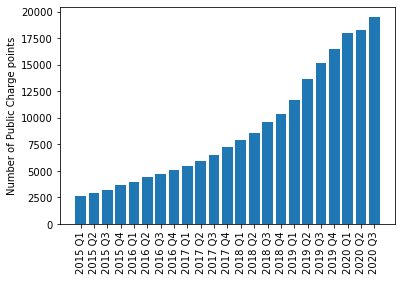

In [34]:
## Plot the trend of the publicly available charging devices in the UK between Q1 2015 and Q3 2020 ##

plt.bar(df_charges_quarter.index,df_charges_quarter['Total  Devices'],.8)
plt.xticks(rotation = 90)
plt.ylabel('Number of Public Charge points')
plt.show()

# Import ULEVs data by postcode district

In [35]:
#Import Ultra Low Emission Vehicles (ULEVs) table
dft_ulev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134a')
dft_ulev = dft_ulev_import[6:-14]
dft_ulev.columns = dft_ulev_import.iloc[5].values
dft_ulev.reset_index(inplace=True, drop=True)

In [36]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_ulev[dft_ulev['2020 Q3']=='c'])/len(dft_ulev)*100) )

Missing 0.27% of entire data


In [37]:
dft_ulev = dft_ulev.replace({'c':0}) # Replace the c values with zeros so that the statistics is not altered 

In [38]:
#Import Battery Electric Vehicles (BEVs) table by postcode
dft_bev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134b')
dft_bev = dft_bev_import[6:-14]
dft_bev.columns = dft_bev_import.iloc[5].values
dft_bev.reset_index(inplace=True, drop=True)

In [39]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_bev[dft_bev['2020 Q3']=='c'])/len(dft_bev)*100))

Missing 2.43% of entire data


In [40]:
dft_bev = dft_bev.replace({'c':0})

In [41]:
dft_bev.head()

,Postcode District 2,2020 Q3,2020 Q2,2020 Q1,2019 Q4,2019 Q3,2019 Q2,2019 Q1,2018 Q4,2018 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
0,AB10,27.0,20.0,24.0,19.0,18.0,17.0,17.0,14.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AB11,28.0,24.0,21.0,21.0,19.0,18.0,17.0,15.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AB12,68.0,52.0,58.0,45.0,41.0,36.0,32.0,29.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AB13,10.0,9.0,11.0,11.0,10.0,9.0,9.0,8.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AB14,15.0,10.0,10.0,10.0,9.0,7.0,7.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
print('Missing {num} Postcode Districts out of {pd_len} ({per:.2f}% of the data)'.format(num = postcode_district_number - len(dft_bev), pd_len = postcode_district_number, per = (1-len(dft_bev)/postcode_district_number)*100))

Missing 358 Postcode Districts out of 2951 (12.13% of the data)


In [43]:
dft_bev_nhb = dft_bev.set_index('Postcode District 2')

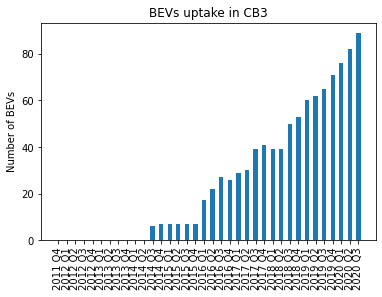

In [44]:
##Plot the NEIGHBOURHOOD level (i.e. Partial Postcode) of BEVs uptake

nhb_val = 'CB3'
nhb_sel = dft_bev_nhb.loc[nhb_val].reindex(index=dft_bev_nhb.loc[nhb_val].index[::-1])
plt.bar(nhb_sel.index,nhb_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Number of BEVs')
plt.title('BEVs uptake in '+nhb_val)
plt.show() 

In [45]:
#Import Plug-in Hybrid Electric Vehicles (PHEVs) data
dft_phev_import = read_ods(dirname+'/veh0134.ods', 'VEH0134c')
dft_phev = dft_phev_import[6:-14]
dft_phev.columns = dft_phev_import.iloc[5].values
dft_phev.reset_index(inplace=True, drop=True)

In [46]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_phev[dft_phev['2020 Q3']=='c'])/len(dft_phev)*100))

Missing 4.56% of entire data


In [47]:
dft_phev = dft_phev.replace({'c':0})

# Import ULEVs data by local authority

In [48]:
#Import Battery Electric Vehicles (BEVs) table by LA
dft_bev_la_import = read_ods(dirname+'/veh0132.ods', 'VEH0132b')
dft_bev_la = dft_bev_la_import[6:-14]
dft_bev_la.columns = dft_bev_la_import.iloc[5].values
dft_bev_la.reset_index(inplace=True, drop=True)

In [49]:
dft_bev_la_sel = dft_bev_la[dft_bev_la['ONS LA Code'].isin(la_list)]
dft_bev_la_sel = dft_bev_la_sel.drop(['Region/Local Authority'],axis = 1).set_index(['ONS LA Code'])
dft_bev_la_sel = dft_bev_la_sel.replace({'c':0})

In [50]:
print('Missing {num} Local Authorities out of {la_len} ({per:.2f}% of the data)'.format(num = len(la_list) - len(dft_bev_la_sel), la_len = len(la_list),  per = 100-(len(dft_bev_la_sel))/len(la_list)*100))

Missing 8 Local Authorities out of 379 (2.11% of the data)


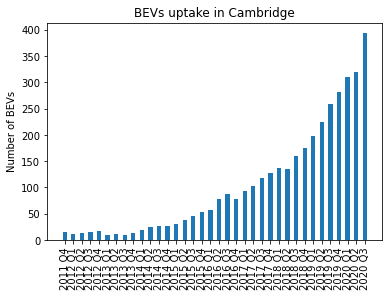

In [51]:
##Plot the Local Authority level of BEVs uptake

la_val = 'Cambridge'
la_sel = dft_bev_la_sel.loc[dic_name[la_val]].reindex(index=dft_bev_la_sel.loc[dic_name[la_val]].index[::-1])
plt.bar(la_sel.index,la_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Number of BEVs')
plt.title('BEVs uptake in '+la_val)
plt.show() 

In [52]:
west_yorkshire = ['Bradford','Calderdale','Kirklees','Leeds','Wakefield']

In [53]:
la_val = west_yorkshire[4]

In [54]:
plot_postcode_district(dft_bev_nhb,la_val)

Missing 1 Postcode Districts out of 18 (5.56% of the data)


## National Trend

In [54]:
dft_bev_all = pd.DataFrame(dft_bev_la.iloc[0][2:])
dft_bev_all = dft_bev_all.reindex(index=dft_bev_all.index[::-1]) # Sort the index (Time) in ascending order 
dft_bev_all.index.names =['Time']
dft_bev_all.columns =['Total BEVs']

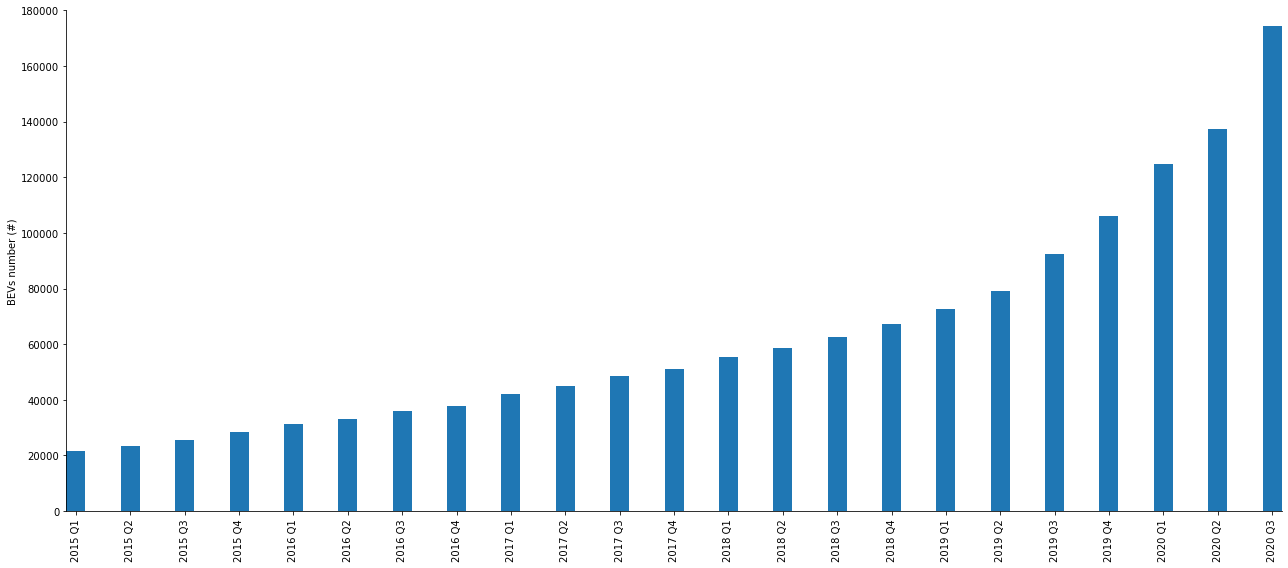

In [55]:
##Plot the National level of BEVs uptake

df_charges_bev = pd.concat([df_charges_quarter,dft_bev_all], axis = 1, join = 'inner')

x = np.arange(len(df_charges_bev.index))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(x, df_charges_bev['Total BEVs'], width, label='BEVs')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs number (#)')
ax.set_xlim(x[0]-width/2,x[-1]+width/2)
ax.set_ylim(0,180000)
#ax.set_title('BEVs VS Pharging  Quarterly Trend')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels(df_charges_bev.index, rotation = 90)
#ax.legend()

fig.tight_layout()

plt.show()
fig.savefig('BEVs_UK.png', bbox_inches='tight', dpi = 300)

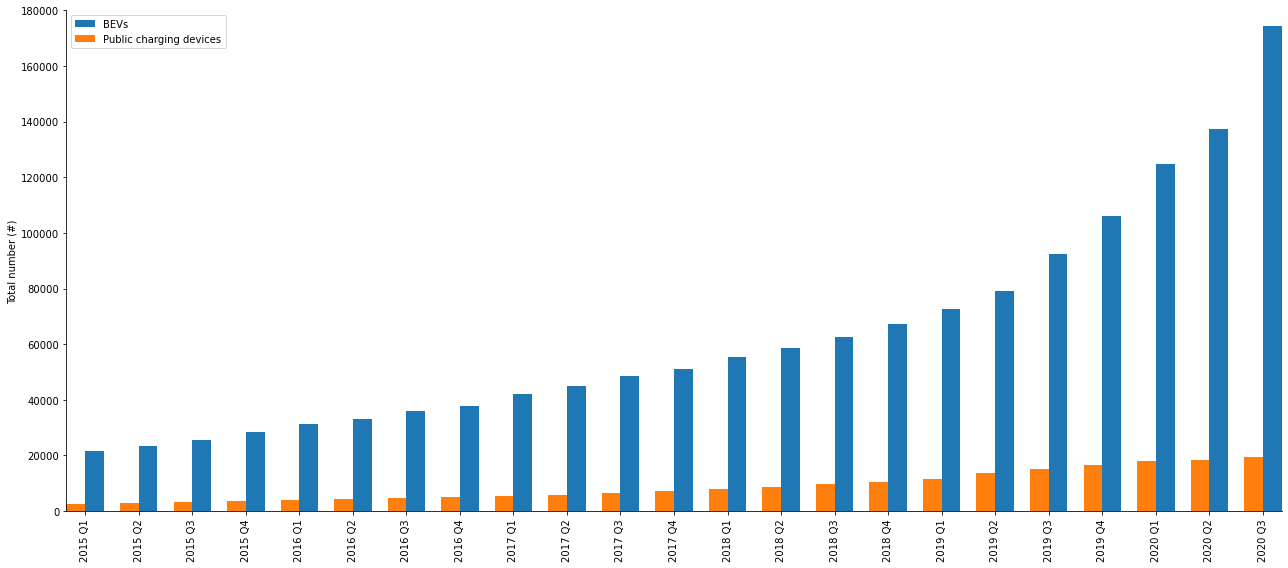

In [56]:
##Plot the National level of BEVs uptake

df_charges_bev = pd.concat([df_charges_quarter,dft_bev_all], axis = 1, join = 'inner')

x = np.arange(len(df_charges_bev.index))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(x + width/2, df_charges_bev['Total BEVs'], width, label='BEVs')
ax.bar(x - width/2, df_charges_bev['Total  Devices'], width, label='Public charging devices')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total number (#)')
ax.set_xlim(x[0]-width,x[-1]+width)
ax.set_ylim(0,180000)
#ax.set_title('BEVs VS Pharging  Quarterly Trend')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels(df_charges_bev.index, rotation = 90)
ax.legend()

fig.tight_layout()

plt.show()
fig.savefig('Devices_BEVs_UK.png', bbox_inches='tight', dpi = 300)

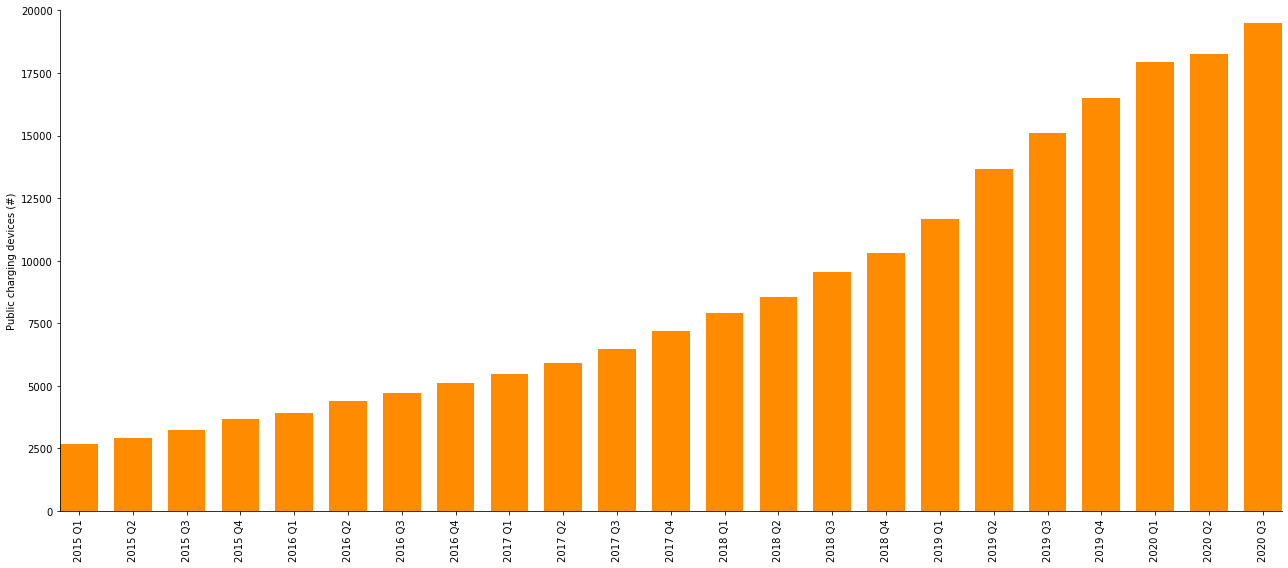

In [57]:
##Plot the National number of charging devices

df_charges_bev = pd.concat([df_charges_quarter,dft_bev_all], axis = 1, join = 'inner')

x = np.arange(len(df_charges_bev.index))
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
rects2 = ax.bar(x, df_charges_bev['Total  Devices'], width, color='darkorange')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Public charging devices (#)')
ax.set_xlim(x[0]-width/2,x[-1]+width/2)
ax.set_ylim(0,20000)
#ax.set_title('BEVs VS Pharging  Quarterly Trend')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels(df_charges_bev.index, rotation = 90)


fig.tight_layout()

plt.show()
fig.savefig('Devices_UK.png', bbox_inches='tight', dpi = 300)

# Import ALL vehicles data by postcode district

In [58]:
sheet_index = sorted(['2020', '2019', '2018', '2017', '2016', '2015'])

In [59]:
df = []

for idx in sheet_index:
    dft_all_import = read_ods(dirname+'/veh0122.ods', idx)
    dft_all_import = dft_all_import[dft_all_import.iloc[:,1].notnull()]
    dft_all = dft_all_import[2:]
    dft_all.columns = dft_all_import.iloc[1].values
    dft_all = dft_all.set_index('Postcode District')
    dft_all_sel = dft_all['Cars']
    dft_all_sel.columns = [idx +' Q'+str(i+1) for i in range(len(dft_all_sel.columns))]
    df.append(dft_all_sel)

In [60]:
dft_all_merged = pd.concat(df, axis =1,join='inner')
dft_all_merged = dft_all_merged.iloc[:,3:]

In [61]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_all_merged[dft_all_merged['2020 Q3']=='c'])/len(dft_all_merged)*100))

Missing 0.52% of entire data


In [62]:
dft_all_merged =dft_all_merged.replace({'c':0})

In [63]:
df_intersect =[]
for item in dft_all_merged.index: 
    if item in dft_bev_nhb.index.tolist():
        df_intersect.append(item)

In [64]:
dft_bev_nhb_sel = dft_bev_nhb[dft_bev_nhb.index.isin(df_intersect)]
dft_all_merged_sel = dft_all_merged[dft_all_merged.index.isin(df_intersect)]

In [65]:
dft_ratio = dft_bev_nhb_sel/dft_all_merged_sel*100
dft_ratio = dft_ratio.replace(np.inf,np.nan)
dft_ratio = dft_ratio.iloc[:,16:]
dft_ratio = dft_ratio.dropna()

In [66]:
print('Missing {num} Postcode Districts out of {pd_len} ({per:.2f}% of the data)'.format(num = postcode_district_number - len(dft_ratio), pd_len = postcode_district_number, per = (1-len(dft_ratio)/postcode_district_number)*100))

Missing 361 Postcode Districts out of 2951 (12.23% of the data)


In [67]:
dft_ratio.describe()

,2015 Q4,2016 Q1,2016 Q2,2016 Q3,2016 Q4,2017 Q1,2017 Q2,2017 Q3,2017 Q4,2018 Q1,2018 Q2,2018 Q3,2018 Q4,2019 Q1,2019 Q2,2019 Q3,2019 Q4,2020 Q1,2020 Q2,2020 Q3
count,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000,2590.000000
mean,0.153617,0.165683,0.172215,0.183312,0.186409,0.206105,0.207707,0.220105,0.239489,0.257311,0.259330,0.267073,0.284969,0.308456,0.328532,0.386271,0.428991,0.481293,0.512626,0.628101
std,2.185063,2.255578,2.178938,2.199325,2.070924,2.152347,2.014570,1.926593,2.022392,2.156114,1.734582,1.635144,1.553085,1.731140,1.648577,1.674846,1.664951,1.722688,1.866995,2.150489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.025843,0.048867,0.053486,0.062576,0.065756,0.075372,0.079052,0.084613,0.092182,0.099322,0.108315,0.128088,0.144689,0.167942,0.180140,0.215270
50%,0.054457,0.064193,0.069795,0.077974,0.081104,0.093373,0.099359,0.109550,0.117437,0.128595,0.136579,0.146108,0.155878,0.165747,0.178245,0.207108,0.231955,0.264835,0.282332,0.338903
75%,0.093186,0.103833,0.112228,0.122679,0.129697,0.145735,0.154356,0.168823,0.181356,0.197640,0.211594,0.223667,0.240295,0.261948,0.286455,0.332187,0.372004,0.419308,0.445799,0.534167
max,107.391304,110.964912,105.627706,106.637168,100.000000,103.846154,98.380567,93.023256,96.734694,104.310345,81.063123,74.844720,70.414201,79.220779,73.684211,71.726190,71.216617,73.053892,80.794702,88.129496


In [68]:
print('Missing {per:.2f}% of England data'.format(per = (1-len(dft_ratio[dft_ratio.index.isin(dic_country[ctry_list[1]])])/len(postcode_active[postcode_active['ctry']==ctry_list[1]]['Postcode District'].unique()))*100)) 
print('Missing {per:.2f}% of N. Ireland data'.format(per = (1-len(dft_ratio[dft_ratio.index.isin(dic_country[ctry_list[2]])])/len(postcode_active[postcode_active['ctry']==ctry_list[2]]['Postcode District'].unique()))*100)) 
print('Missing {per:.2f}% of Scotland data'.format(per = (1-len(dft_ratio[dft_ratio.index.isin(dic_country[ctry_list[0]])])/len(postcode_active[postcode_active['ctry']==ctry_list[0]]['Postcode District'].unique()))*100)) 
print('Missing {per:.2f}% of Wales data'.format(per = (1-len(dft_ratio[dft_ratio.index.isin(dic_country[ctry_list[3]])])/len(postcode_active[postcode_active['ctry']==ctry_list[3]]['Postcode District'].unique()))*100)) 

Missing 7.94% of England data
Missing 8.75% of N. Ireland data
Missing 30.77% of Scotland data
Missing 31.28% of Wales data


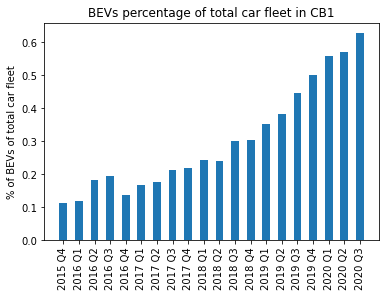

In [69]:
##Plot the NEIGHBOURHOOD level (i.e. Partial Postcode) of BEVs proportion to total car fleet

nhb_val = 'CB1'
nhb_sel = dft_ratio.loc[nhb_val]
plt.bar(nhb_sel.index,nhb_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('% of BEVs of total car fleet')
plt.title('BEVs percentage of total car fleet in '+nhb_val)
plt.show() 

In [70]:
west_yorkshire

['Bradford', 'Calderdale', 'Kirklees', 'Leeds', 'Wakefield']

Missing 0 Postcode Districts out of 23 (0.00% of the data)


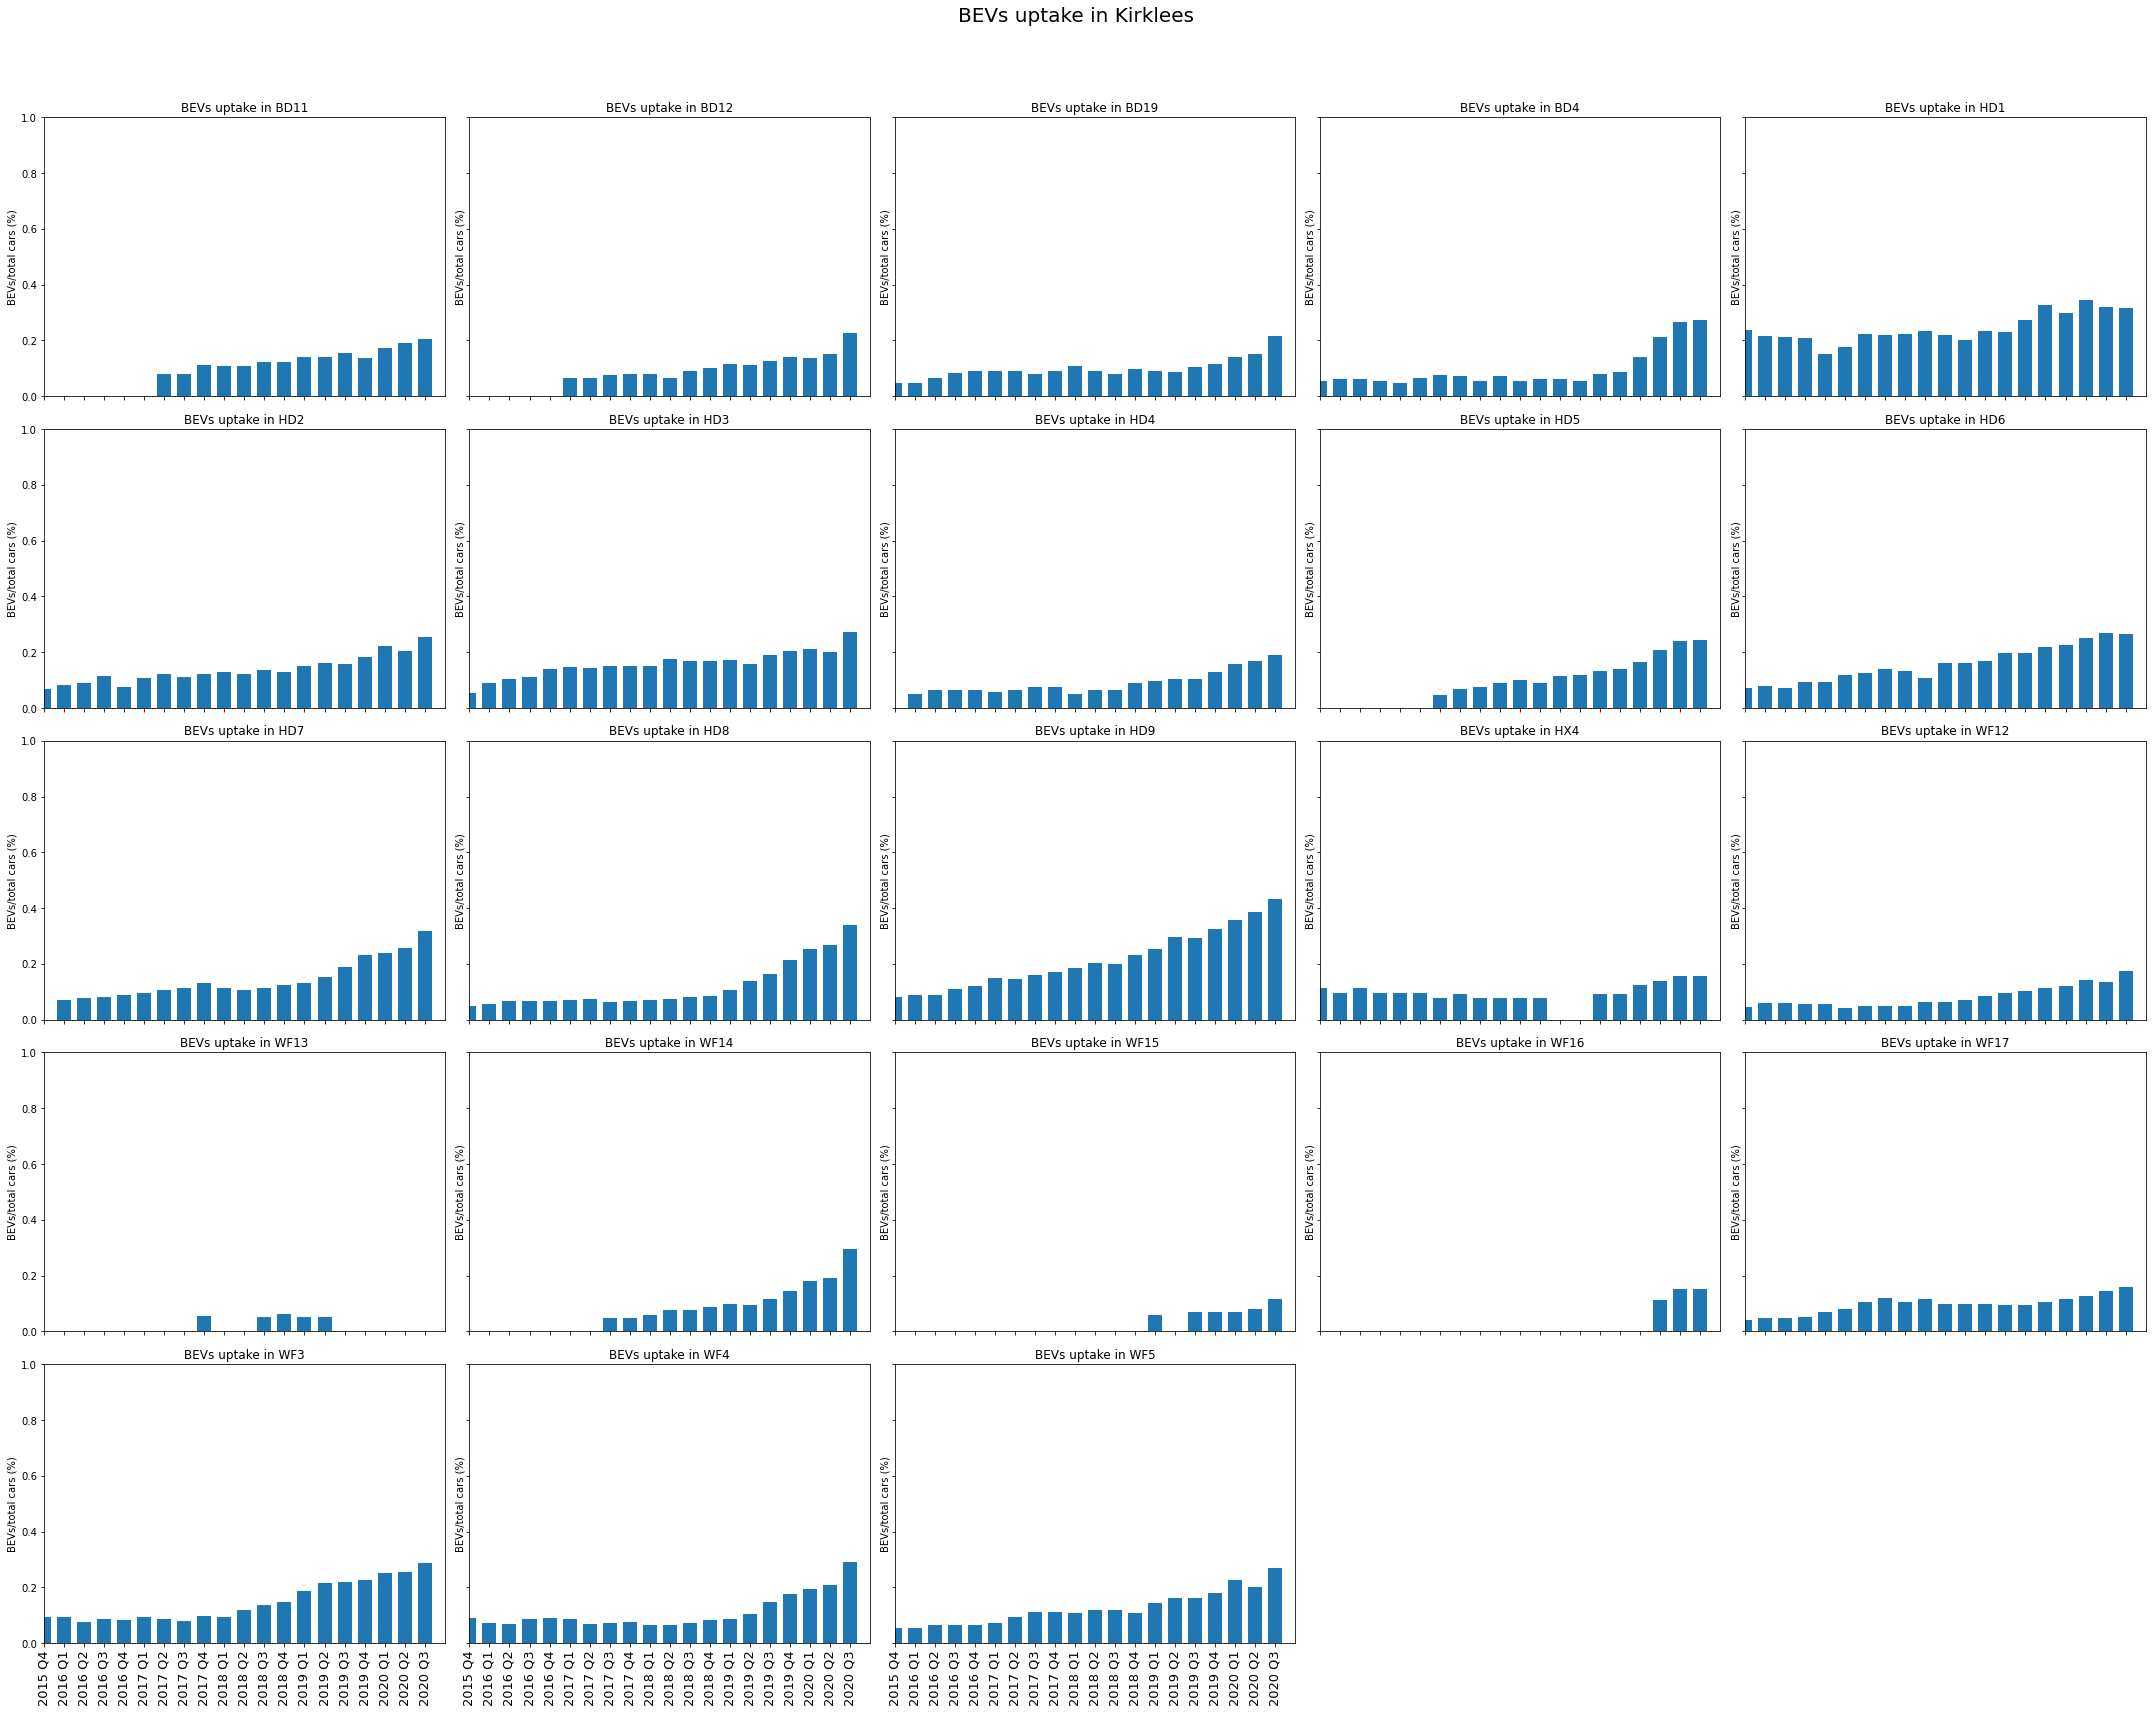

In [432]:
plot_postcode_district_percentage(dft_ratio,west_yorkshire[2])

In [71]:
pd_wy = np.array([])
for item in west_yorkshire:
    pd_wy = np.append(pd_wy,dic_la[dic_name[item]])

In [72]:
postcode_westyorkshire = np.unique(pd_wy).tolist()

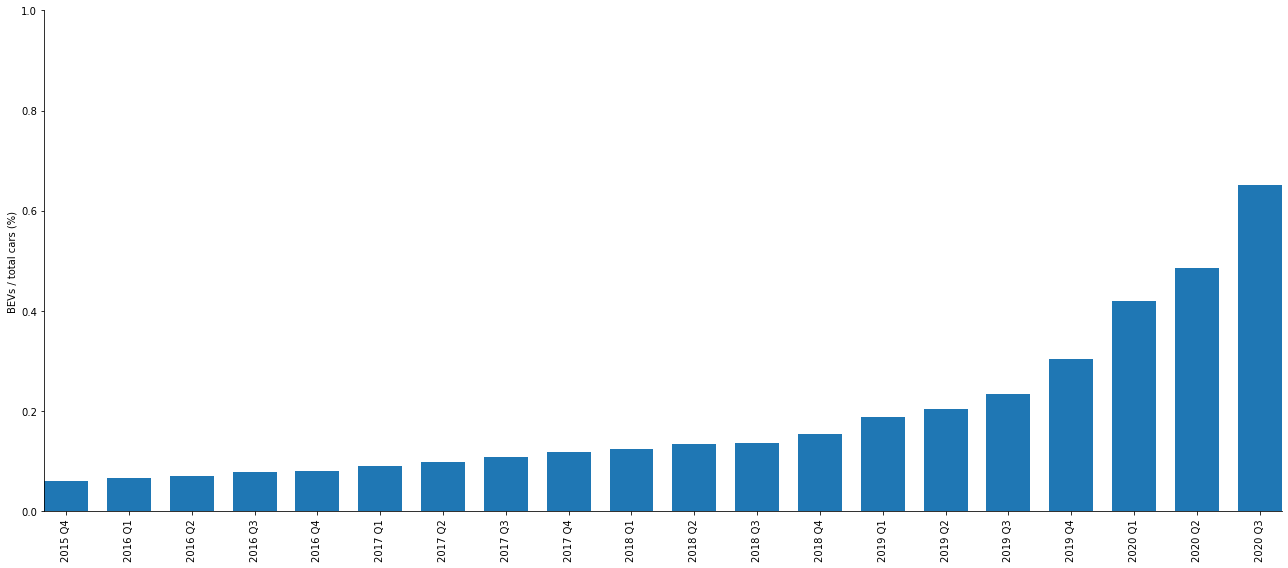

In [161]:
##Plot the BEVs uptake for West Yorkshire Combined Authority 

dft_wy = (100*dft_bev_nhb_sel[dft_bev_nhb_sel.index.isin(postcode_westyorkshire)].sum()/dft_all_merged_sel[dft_all_merged_sel.index.isin(postcode_westyorkshire)].sum()).dropna()

x = np.arange(len(dft_wy.index))
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(x, dft_wy, width)

ymax = math.ceil(dft_wy.max())
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs / total cars (%)')
ax.set_xlim(x[0]-width/2,x[-1]+width/2)
ax.set_ylim(0,ymax)
#ax.set_title('BEVs VS Pharging  Quarterly Trend')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels(dft_wy.index, rotation = 90)

fig.tight_layout()

plt.show()
fig.savefig('BEVs_uptake_WY.png', bbox_inches='tight', dpi = 300)

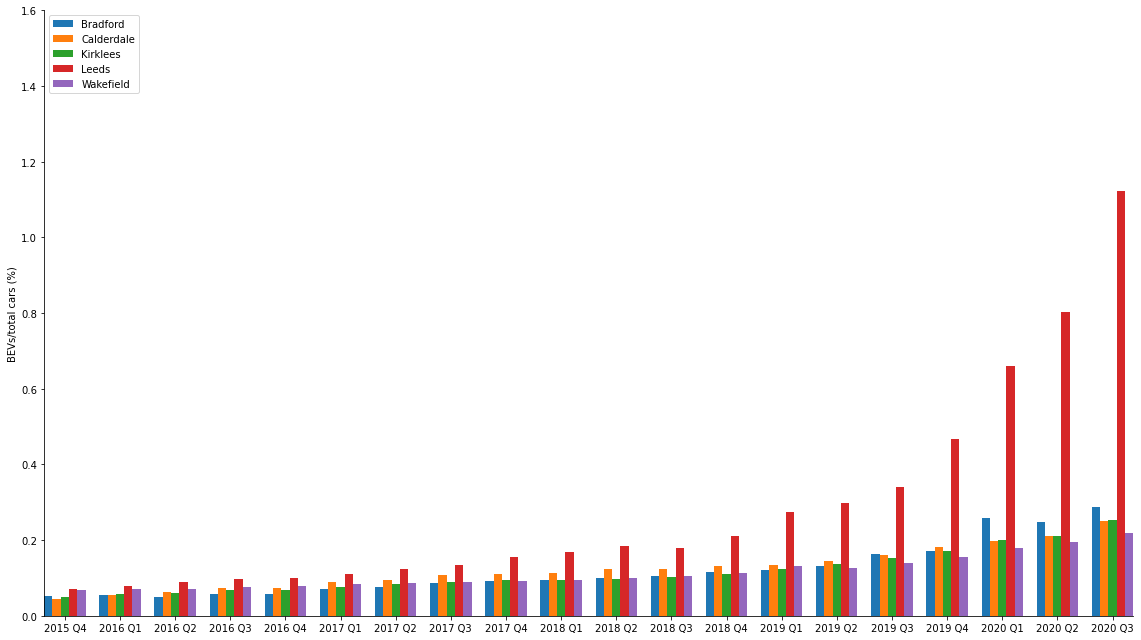

In [425]:
dft_wt_all = []
for item in west_yorkshire:
    dft_wt_all.append( (100*dft_bev_nhb_sel[dft_bev_nhb_sel.index.isin(dic_la[dic_name[item]])].sum()/dft_all_merged_sel[dft_all_merged_sel.index.isin(dic_la[dic_name[item]])].sum()).dropna())

    
dft_wy_all = pd.DataFrame(dft_wt_all)
dft_wy_all['LA'] = west_yorkshire
dft_wy_all = dft_wy_all.set_index('LA')

x = np.arange(len(dft_wy_all.iloc[0]))
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(x -2*width, dft_wy_all.loc[west_yorkshire[0]], width, label=west_yorkshire[0])
ax.bar(x -width, dft_wy_all.loc[west_yorkshire[1]], width, label=west_yorkshire[1])
ax.bar(x , dft_wy_all.loc[west_yorkshire[2]], width, label=west_yorkshire[2])
ax.bar(x +width, dft_wy_all.loc[west_yorkshire[3]], width, label=west_yorkshire[3])
ax.bar(x +2*width, dft_wy_all.loc[west_yorkshire[4]], width, label=west_yorkshire[4])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs/total cars (%)')
#ax.set_title('BEVs Quarterly Trend')
ax.set_xticks(x)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(x[0]-2.5*width,x[-1]+2.5*width)
ax.set_ylim(0,1.6)
ax.set_xticklabels(dft_wy_all.iloc[0].index)
ax.legend(loc= 2)

fig.tight_layout()

plt.show()
fig.savefig('BEVs_uptake_WY_by_LA.png', bbox_inches='tight', dpi = 300)

In [372]:
#for item in west_yorkshire:
#    plot_la_ratio(dft_bev_nhb_sel,dft_all_merged_sel,item)

In [73]:
def plot_la_ratio(left_dataframe,right_dataframe,la_name):

    dft_sel = (100*left_dataframe[left_dataframe.index.isin(dic_la[dic_name[la_name]])].sum()/right_dataframe[right_dataframe.index.isin(dic_la[dic_name[la_name]])].sum()).dropna()
    x = np.arange(len(dft_sel.index))
    width = 0.7  # the width of the bars

    fig, ax = plt.subplots(figsize=(18,8))
    ax.bar(x, dft_sel, width)

    ymax = math.ceil(dft_sel.max())
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('BEVs / total cars (%)')
    ax.set_xlim(x[0]-width/2,x[-1]+width/2)
    ax.set_ylim(0,ymax)
    ax.set_title('BEVs uptake in '+la_name)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(x)
    ax.set_xticklabels(dft_sel.index, rotation = 90)

    fig.tight_layout()

    plt.show()
    fig.savefig('BEVs_uptake_'+str(la_name)+'.png', bbox_inches='tight', dpi = 300)

# Import private chargers data

In [74]:
fund_df_import = pd.read_excel(dirname+"/EIR_E0019012.xlsx")
fund_df_import = fund_df_import[fund_df_import.iloc[:,2].notnull()].dropna(axis =1)

fund_df = fund_df_import[1:]
fund_df.columns = fund_df_import.iloc[0].values
fund_df =fund_df.set_index('Postcode District')
fund_df.head()

,EVHS Grants,DRS Grants
Postcode District,,
AB1,0,0
AB10,17,…
AB11,…,0
AB12,59,…
AB13,19,…


In [75]:
# As stated in the file, all postcode districts with counts of at least one but fewer than ten have are indicated as "…".
#For statistical purpose, a lower estimate of this value is 1 and therefore "…" is replaced by the value 1. 
fund_df = fund_df.replace({'…':1})

# Create a DataFrame containing the necessary information per Local Authority



In [76]:
columns_name = ['ONS LA Code','Local Authority','Total electric vehicles (BEVs)','Total public charging devices','Total public charging devices per 100,000 population','Total private charging devices','Charging devices usage']
summary_dataframe = pd.DataFrame({item:[] for item in columns_name})

for area in la_list:
    total_electric_vehicles = dft_bev_la[dft_bev_la['ONS LA Code']==area]['2020 Q3'].mean()
    public_charging_devices,public_charging_devices_density = dft_charging_devices_available[dft_charging_devices_available['LA / Region Code']==area][['Total public\ncharging devices','Charging devices per\n100,000 population']].mean()
    evhs_grant,drs_grant = fund_df[fund_df.index.isin(dic_la[area])][['EVHS Grants','DRS Grants']].sum()
    
    
    total_public_charging_devices = int(public_charging_devices) 
    total_public_charging_devices_density = public_charging_devices_density
    total_private_charging_devices = int(evhs_grant + drs_grant)
    charging_devices_usage = private_or_public_charging(total_private_charging_devices, total_electric_vehicles)
    
    summary_dataframe = summary_dataframe.append(pd.DataFrame([[area,dic_code[area],total_electric_vehicles,total_public_charging_devices,total_public_charging_devices_density,total_private_charging_devices,charging_devices_usage]], columns = columns_name))
    
summary_dataframe = summary_dataframe.set_index('Local Authority') # Set the Local Authority name as the DataFrame index

# Print the lookup table for each Local Authority

In [77]:
dic_name['Shetland Islands']

'S12000027'

In [78]:
##Lookup table for each local authority number of EVs, public and private charging devices 
la_code = 'S12000027'

print(summary_dataframe.loc[dic_code[la_code]])

ONS LA Code                                                         S12000027
Total electric vehicles (BEVs)                                       29.00000
Total public charging devices                                        17.00000
Total public charging devices per 100,000 population                 74.17103
Total private charging devices                                        2.00000
Charging devices usage                                  Predomintantly public
Name: Shetland Islands, dtype: object


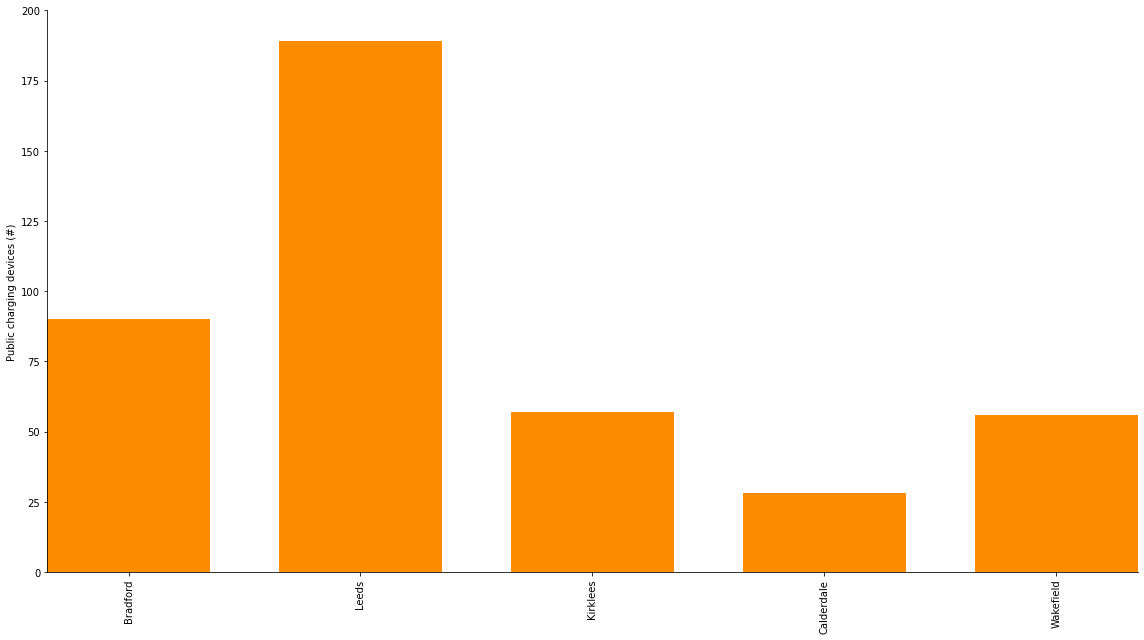

In [426]:
la_selection = west_yorkshire


df_selection = summary_dataframe[summary_dataframe.index.isin(la_selection)]


x = np.arange(len(df_selection.index))
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(x, df_selection['Total public charging devices'], width, color = 'darkorange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Public charging devices (#)')
ax.set_xlim(x[0]-width/2,x[-1]+width/2)
ax.set_ylim(0,200)
ax.set_xticks(x)
ax.set_xticklabels(df_selection.index, rotation = 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()

plt.show()
#fig.savefig('Devices_WYCA.png', bbox_inches='tight', dpi = 300)

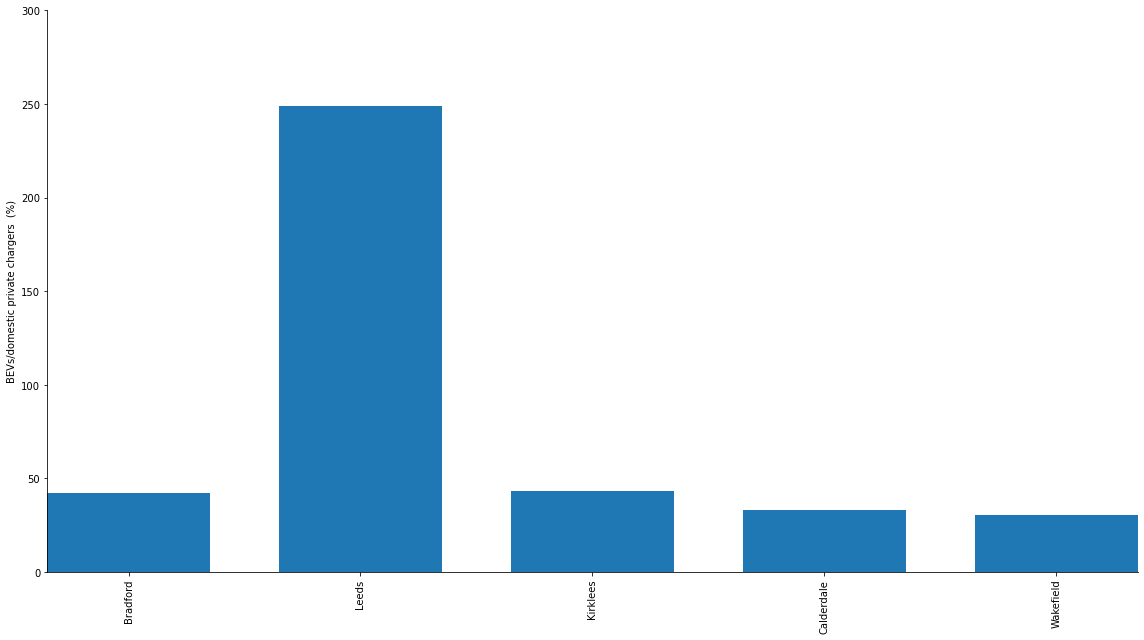

In [427]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(x, 100*df_selection['Total electric vehicles (BEVs)']/df_selection['Total private charging devices'], width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs/domestic private chargers  (%)')
ax.set_xlim(x[0]-width/2,x[-1]+width/2)
ax.set_ylim(0,300)
ax.set_xticks(x)
ax.set_xticklabels(df_selection.index, rotation = 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()

plt.show()
fig.savefig('BEVs_private_devices_WYCA.png', bbox_inches='tight', dpi = 300)

# Identify Local Authorities where the commercial fleet is statistically significant

In [80]:
#Subselect for the dataframe the local authorities where there are more EVs than private chargers 
ratios = summary_dataframe['Total electric vehicles (BEVs)']/summary_dataframe['Total private charging devices']
old_ratios = len(ratios)

In [81]:
#Import ULEVs keepership table by LA
dft_keep_import = read_ods(dirname+'/veh0132.ods', 'VEH0132d')
dft_keep_import = dft_keep_import[dft_keep_import.iloc[:,1].notnull()]

dft_keep = dft_keep_import[1:]
dft_keep.columns = dft_keep_import.iloc[0]
dft_keep.reset_index(inplace=True, drop=True)
dft_keep.head()

5,ONS LA Code,Region/Local Authority,Private,Company
0,K02000001,United Kingdom,177147.0,190476.0
1,K03000001,Great Britain,175101.0,188336.0
2,E92000001,England,158025.0,175937.0
3,E12000001,North East,4093.0,1462.0
4,E06000047,County Durham UA,846.0,267.0


In [82]:
dft_keep_sel = dft_keep[dft_keep['ONS LA Code'].isin(la_list)]

In [83]:
#Select LAs for which the number of company ULEVs is twice the number of private ULEVs

outliers_code = dft_keep_sel[dft_keep_sel['Company'] > 2 *dft_keep_sel['Private']]['ONS LA Code'].tolist()
outliers_la = [dic_code[item] for item in outliers_code]

In [84]:
#Remove the previously identified LAs from the selected list rsel

ratios =ratios[~ratios.index.isin(outliers_la)]

print('{val} local authorities were removed from the list ({per:.2f}% of the data)'.format(val = old_ratios-len(ratios), per = (1-len(ratios)/old_ratios)*100 ))

ratios_sel=ratios[ratios!=np.inf]

print('{per:.2f}% of the data is infinity'.format(per = (1 -len(ratios_sel)/len(ratios))*100))

ratios_sel=ratios_sel.dropna()

print('{per:.2f}% of the data is NaN'.format(per = (1 - len(ratios_sel)/len(ratios))*100))
old_rsel = len(ratios_sel)

21 local authorities were removed from the list (5.54% of the data)
0.28% of the data is infinity
2.51% of the data is NaN


# Investigate top and bottom 10 Local authorities for public charger usage

In [85]:
ratios_gt_one = ratios_sel[ratios_sel >1]

print('{per:.2f}% of the local authorities have more BEVs than private chargers'.format(per = len(ratios_gt_one)/len(ratios)*100))

9.78% of the local authorities have more BEVs than private chargers


In [86]:
#Mean and median values for the BEVs/Private chargers > 1, respectively 
print(ratios_gt_one.mean())
print(ratios_gt_one.median())

2.6255857348963305
1.5555555555555556


In [87]:
#Standard Deviation values for the BEVs/Private chargers > 1
print(ratios_gt_one.std())

2.757968284231699


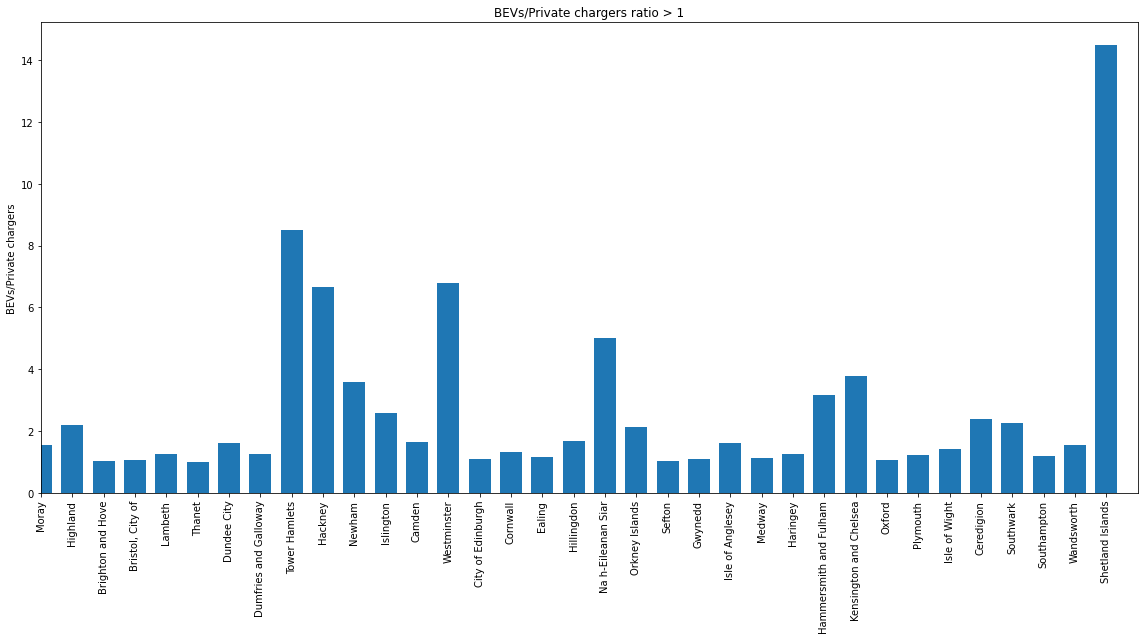

In [88]:
x = np.arange(len(ratios_gt_one))
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects1 = ax.bar(x, ratios_gt_one, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs/Private chargers')
ax.set_title('BEVs/Private chargers ratio > 1')
ax.set_xticks(x)
ax.set_xlim(0,len(ratios_gt_one))
ax.set_xticklabels(ratios_gt_one.index, rotation = 90)
#ax.legend()

fig.tight_layout()

plt.show()

fig.savefig('ratio.png')

In [89]:
#Top 10 Local Authorities with the highest BEVs/private chargers ratio
ratios_gt_one.sort_values(ascending = False).head(10)

Local Authority
Shetland Islands          14.500000
Tower Hamlets              8.500000
Westminster                6.790514
Hackney                    6.672131
Na h-Eileanan Siar         5.000000
Kensington and Chelsea     3.794872
Newham                     3.597015
Hammersmith and Fulham     3.183544
Islington                  2.580189
Ceredigion                 2.384615
dtype: float64

In [90]:
#Bottom 10 Local Authorities with the highest BEVs/private chargers ratio
ratios_gt_one.sort_values().head(10)

Local Authority
Thanet               1.010929
Sefton               1.045894
Brighton and Hove    1.047945
Bristol, City of     1.054176
Oxford               1.075949
City of Edinburgh    1.084479
Gwynedd              1.092437
Medway               1.130926
Ealing               1.172932
Southampton          1.178832
dtype: float64

# Variation in BEVs uptake within a select few LAs

In [91]:
ratios_sel.sort_values(ascending=False).head(15)

Local Authority
Shetland Islands          14.500000
Tower Hamlets              8.500000
Westminster                6.790514
Hackney                    6.672131
Na h-Eileanan Siar         5.000000
Kensington and Chelsea     3.794872
Newham                     3.597015
Hammersmith and Fulham     3.183544
Islington                  2.580189
Ceredigion                 2.384615
Southwark                  2.254777
Highland                   2.193548
Orkney Islands             2.127273
Hillingdon                 1.666996
Camden                     1.654341
dtype: float64

In [92]:
ratios_sel.sort_values(ascending=False)[175:185]

Local Authority
Kirklees                0.433810
West Lothian            0.426404
Ashford                 0.425461
Surrey Heath            0.425141
Tendring                0.424929
South Cambridgeshire    0.423645
Maidstone               0.422983
Bradford                0.422939
East Hampshire          0.422018
West Dunbartonshire     0.421875
dtype: float64

In [93]:
ratios_sel.sort_values(ascending=False).tail(15)

Local Authority
North Tyneside             0.099470
County Durham              0.099349
Gateshead                  0.096206
South Derbyshire           0.095762
Mansfield                  0.094025
South Tyneside             0.093242
Staffordshire Moorlands    0.093203
Sunderland                 0.092546
Corby                      0.090465
Middlesbrough              0.089939
Gedling                    0.089325
Broxtowe                   0.075131
Melton                     0.071565
Ashfield                   0.065657
Bolsover                   0.061779
dtype: float64

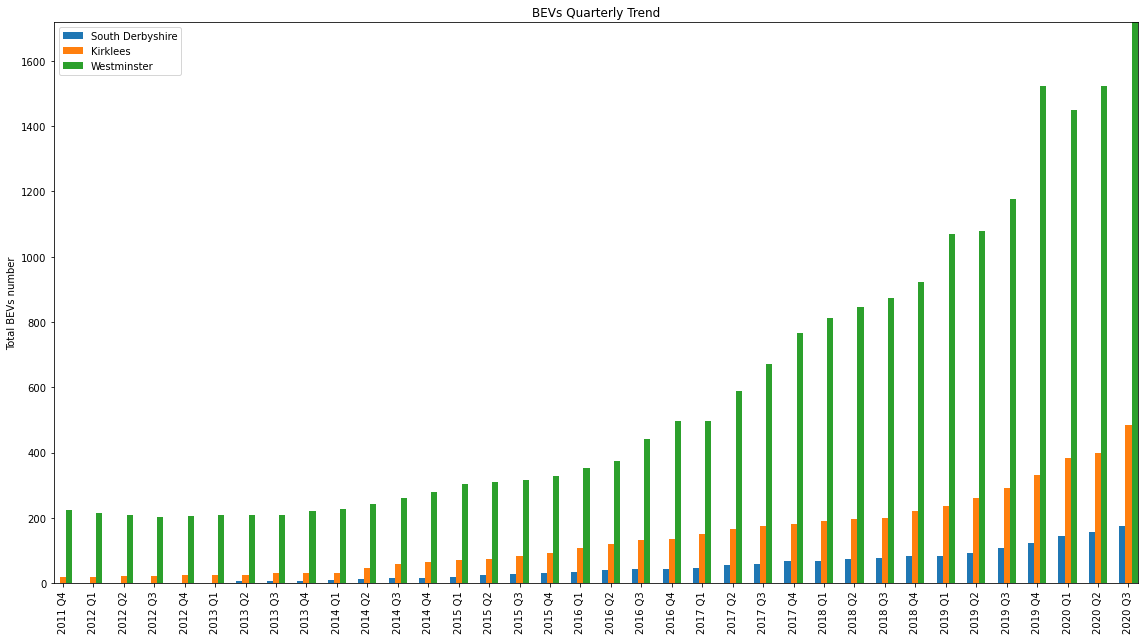

In [203]:
la_selection = ['Westminster','Kirklees','South Derbyshire']
df_selection =[]

for area in la_selection:
    df_selection.append(dft_bev_la_sel.loc[dic_name[area]].reindex(index=dft_bev_la_sel.loc[dic_name[area]].index[::-1]))

x = np.arange(len(df_selection[0].index))
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects1 = ax.bar(x -width, df_selection[2], width, label=la_selection[2])
rects2 = ax.bar(x, df_selection[1], width, label=la_selection[1])
rects3 = ax.bar(x + width,  df_selection[0], width, label=la_selection[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total BEVs number')
ax.set_title('BEVs Quarterly Trend')
ax.set_xticks(x)
ax.set_xticklabels(df_selection[0].index, rotation = 90)
ax.legend()
ax.autoscale(tight=True)

fig.tight_layout()

plt.show()

# Import vehicle annual mileage by local authority

In [94]:
dft_vehicle_miles_import = read_ods(dirname+'/tra8901.ods', 'TRA8901', headers=False)
dft_vehicle_miles_import = dft_vehicle_miles_import[dft_vehicle_miles_import.iloc[:,4].notnull()]

dft_vehicle_miles = dft_vehicle_miles_import.iloc[1:]
dft_vehicle_miles.columns = dft_vehicle_miles_import.iloc[0]
dft_vehicle_miles = dft_vehicle_miles.dropna(axis=1)

dft_vehicle_miles = dft_vehicle_miles[dft_vehicle_miles['LA Code'].isin(la_list)]
dft_vehicle_miles.reset_index(inplace=True, drop=True) #reset the index
dft_vehicle_miles.insert(loc=1, column='Local Authority', value=[dic_code[item] for item in dft_vehicle_miles['LA Code']])
dft_vehicle_miles = dft_vehicle_miles.set_index('LA Code')

In [95]:
print('Missing {num} Local Authorities out of {la_len} ({per:.2f}% of the data)'.format(num = len(la_list) - len(dft_vehicle_miles), 
                                                                                        la_len = len(la_list), 
                                                                                        per = (1-len(dft_vehicle_miles)/len(la_list))*100))

Missing 200 Local Authorities out of 379 (52.77% of the data)


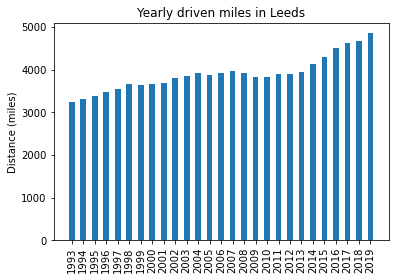

In [96]:
##Plot the Local Authority level of yearly miles driven

la_val = 'Leeds'
la_sel = dft_vehicle_miles.loc[dic_name[la_val]][1:]
la_sel.index = [str(i) for i in range(1993,2020)]
plt.bar(la_sel.index,la_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Distance (miles)')
plt.title('Yearly driven miles in '+la_val)
plt.show() 

# Interactive plots (WORK IN PROGRESS)

## Local authority level

In [97]:
la_geo = subdirla+'/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.geojson'

In [98]:
gpdimport = gpd.read_file(la_geo)

In [99]:
gpdimport = gpdimport.set_index('LAD20CD')
gpdfinal = gpdimport.drop(['OBJECTID','LAD20NM','LAD20NMW','BNG_E','BNG_N','LONG','LAT','Shape__Area','Shape__Length'], axis =1)
gpdimport.head()

,OBJECTID,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,geometry
LAD20CD,,,,,,,,,,
E06000001,1,Hartlepool,,447160,531474,-1.27018,54.67614,9.376780e+07,68415.419287,"MULTIPOLYGON (((-1.23001 54.62512, -1.22990 54..."
E06000002,2,Middlesbrough,,451141,516887,-1.21099,54.54467,5.385868e+07,43775.371865,"MULTIPOLYGON (((-1.27714 54.54789, -1.27720 54..."
E06000003,3,Redcar and Cleveland,,464361,519597,-1.00608,54.56752,2.451441e+08,94926.255586,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54..."
E06000004,4,Stockton-on-Tees,,444940,518183,-1.30664,54.55691,2.049028e+08,118347.998943,"MULTIPOLYGON (((-1.27694 54.54718, -1.27694 54..."
E06000005,5,Darlington,,428029,515648,-1.56835,54.53534,1.974858e+08,105777.871675,"POLYGON ((-1.63800 54.61720, -1.63767 54.61670..."


In [100]:
len(gpdimport)

379

In [101]:
df_left = gpdfinal
df_right = dft_bev_la_sel

In [102]:
df_concat = pd.concat([gpdfinal,dft_bev_la_sel], join='inner',axis=1).reset_index()
df_concat.head()

,index,geometry,2020 Q3,2020 Q2,2020 Q1,2019 Q4,2019 Q3,2019 Q2,2019 Q1,2018 Q4,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
0,E06000001,"MULTIPOLYGON (((-1.23001 54.62512, -1.22990 54...",70.0,60.0,56.0,47.0,45.0,39.0,38.0,36.0,...,7.0,6.0,6.0,7.0,8.0,8.0,9.0,9.0,6.0,5.0
1,E06000002,"MULTIPOLYGON (((-1.27714 54.54789, -1.27720 54...",59.0,41.0,42.0,38.0,41.0,34.0,32.0,30.0,...,13.0,12.0,13.0,13.0,7.0,6.0,5.0,0.0,0.0,0.0
2,E06000003,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54...",87.0,77.0,70.0,62.0,60.0,52.0,40.0,39.0,...,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E06000004,"MULTIPOLYGON (((-1.27694 54.54718, -1.27694 54...",181.0,143.0,136.0,121.0,111.0,99.0,91.0,87.0,...,32.0,28.0,27.0,27.0,27.0,28.0,28.0,29.0,29.0,29.0
4,E06000005,"POLYGON ((-1.63800 54.61720, -1.63767 54.61670...",184.0,151.0,142.0,133.0,120.0,95.0,94.0,91.0,...,14.0,13.0,14.0,12.0,11.0,8.0,8.0,8.0,7.0,8.0


In [103]:
print('Missing {num} Local Authorities out of {la_len} ({per:.2f}% of the data)'.format(num = len(la_list) - len(df_concat), 
                                                                                        la_len = len(la_list), 
                                                                                        per = (1-len(df_concat)/len(la_list))*100))

Missing 8 Local Authorities out of 379 (2.11% of the data)


In [104]:
n_periods, n_sample = df_right.shape[1],df_right.shape[1]


datetime_index = pd.date_range('2011-12-1', periods=n_periods, freq='3M')
dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = dt_index_epochs.astype('U10')

In [105]:
styledata = {}

for area in df_right.index:
    df = pd.DataFrame(
        {'color': df_right.loc[area].values,
         'opacity': 0*np.random.normal(size=n_periods)},
        index=dt_index
    )
    df = df.cumsum()
    df.sample(n_sample, replace=False).sort_index()
    df.loc[:,'opacity'] = np.ones(n_periods)
    styledata[area] = df

In [106]:

max_color, min_color = 2, 0

for area, data in styledata.items():
    max_color = max(max_color, data['color'].max())
    min_color = max(min_color, data['color'].min())
        
cmap = linear.BuPu_06.scale(min_color, max_color)

for area, data in styledata.items():
    data['color'] = data['color'].apply(cmap)
    data['opacity'] = (data['opacity'])
    data['opacity'] = (data['opacity'])

In [107]:
styledict = {
    str(area): data.to_dict(orient='index') for
    area, data in styledata.items()
}

In [108]:
m = folium.Map([54.7, -4.6], tiles='cartodbpositron', zoom_start=5)

g = TimeSliderChoropleth(
    df_left.to_json(),
    styledict=styledict,

).add_to(m)

choropleth = folium.Choropleth(
    geo_data=df_concat,
    data=df_concat,
    columns=['index', '2020 Q3'],
    key_on='feature.properties.index',
    fill_color= 'BuPu',
    fill_opacity=0.0,
    line_opacity=0.0,
    legend_name='BEVs (#)',
    smooth_factor=0).add_to(m)

style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['index'], style=style_function, labels=False))
folium.LayerControl().add_to(m)

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [506]:
#m

In [476]:
m.save('Timeseries.html')

## Postcode district level

In [109]:
#Import the files containing the coordinates for each postcode district and combine them in a single dataframe 

for item in postcode_area_list:
    
    if item=='AB':
        filename = item+'.kml'
        file_path = subdirpd+'/'+filename

        df_bound = gpd.read_file(file_path, driver='KML')
    else:
        filename = item+'.kml'
        file_path = subdirpd+'/'+filename

        polys = gpd.read_file(file_path, driver='KML')
        df_bound = df_bound.append(polys, ignore_index=True)

        
df_postcode_district = df_bound[df_bound['Name'].isin(postcode_district_list)].set_index('Name')
df_postcode_district.index.name = 'Postcode District'
df_postcode_district = df_postcode_district.sort_index()

In [110]:
df_postcode_district = df_postcode_district.drop('Description',axis=1)

## IMD plot

In [111]:
df_left = df_postcode_district
df_right = dft_ratio.drop('TW6')

In [112]:
df_concat = pd.concat([df_left,df_imd,df_right], join='inner',axis=1).reset_index()

In [113]:
print('Missing {num} Postcode Districts out of {pd_len} ({per:.2f}% of the data)'.format(num = postcode_district_number - len(df_concat), pd_len = postcode_district_number, per = (1-len(df_concat)/postcode_district_number)*100))

Missing 367 Postcode Districts out of 2951 (12.44% of the data)


In [114]:
x_map=df_concat.centroid.x.mean()
y_map=df_concat.centroid.y.mean()
print(x_map,y_map)

-1.8378135142449064 52.86621361495261


In [195]:
mymap = folium.Map(location=[y_map, x_map], zoom_start=5,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)

myscale = (df_concat['IMD Mean'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

choropleth = folium.Choropleth(
 geo_data=df_concat,
 name='IMD',
 data=df_concat,
 columns=['index','IMD Mean'],
 key_on="feature.properties.index",
 fill_color='YlGnBu',
 threshold_scale=myscale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='IMD in %',
 smooth_factor=0
).add_to(mymap)

myscale = (df_concat['2020 Q3'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()

choropleth = folium.Choropleth(
 geo_data=df_concat,
 name='BEVs uptake',
 data=df_concat,
 columns=['index','2020 Q3'],
 key_on="feature.properties.index",
 fill_color='YlGnBu',
 threshold_scale=myscale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='BEVs uptake in %',
 smooth_factor=0
).add_to(mymap)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}


highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    df_concat,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['index','IMD Mean','2020 Q3'],
        aliases=['Postcode District: ','Index Mass Deprivation in %: ','BEVs/total cars in %:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mymap.add_child(NIL)
mymap.keep_in_front(NIL)
folium.LayerControl().add_to(mymap)




# choropleth.geojson.add_child(
#     folium.features.GeoJsonTooltip(fields =('index','IMD Mean'), style=style_function, labels=False))
# folium.LayerControl().add_to(mymap)    

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be 

In [ ]:
mymap.save('IMD_BEV.html')

In [805]:
#mymap

In [115]:
x = df_concat['IMD Mean'].values.reshape((-1,1))

In [116]:
y = df_concat['2020 Q3'].values

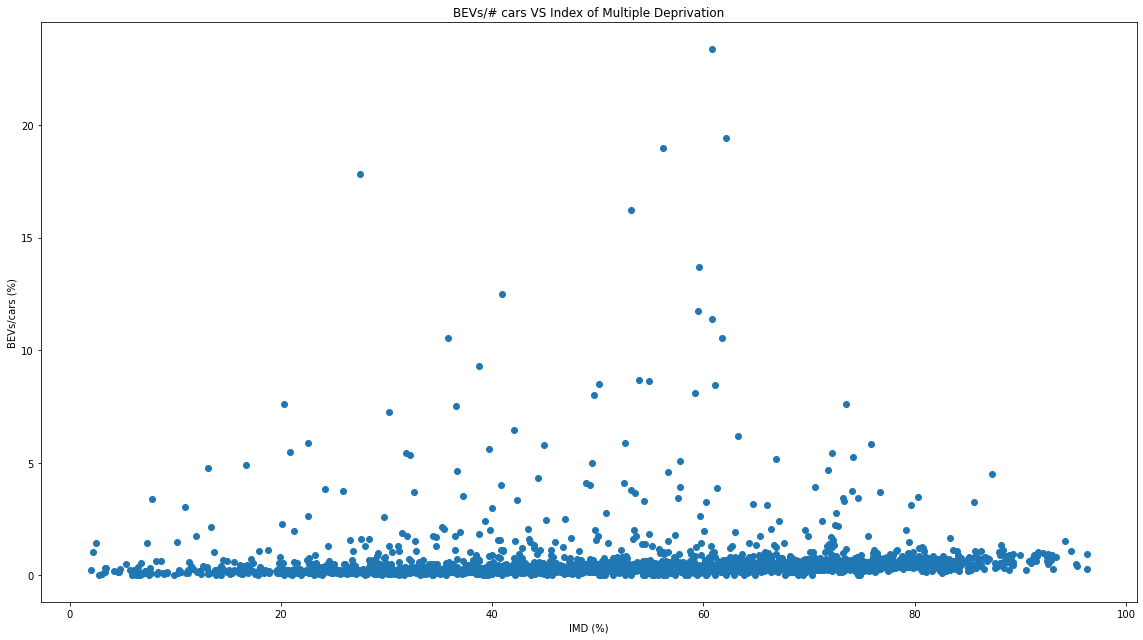

In [129]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(x,y)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('BEVs/# cars VS Index of Multiple Deprivation')
ax.set_ylabel('BEVs/cars (%)')
ax.set_xlabel('IMD (%)')



fig.tight_layout()
plt.show()
fig.savefig('IMD_BEVs%_scatter.png', bbox_inches='tight', dpi = 300)

In [130]:
model = LinearRegression()

In [131]:
model = model.fit(x,y)

In [138]:
print('Gradient: ', model.coef_[0])
print('Intercept: ', model.intercept_)
print('R^2: ', model.score(x,y))

Gradient:  0.004135542954214099
Intercept:  0.37656596636457335
R^2:  0.003976768156933375


##  BEVs / domestic charger

In [188]:
fund_wy = fund_df[fund_df.index.isin(postcode_westyorkshire)].sum(axis=1)

In [189]:
df_right = pd.concat([dft_bev_nhb[dft_bev_nhb.index.isin(postcode_westyorkshire)]['2020 Q3'],fund_wy[fund_wy>0]], axis=1, join='inner')

In [190]:
df_right['ratio'] = df_right['2020 Q3']/df_right[0]*100

In [191]:
df_left = df_postcode_district
#df_right = df_right.drop(['LS1','LS2','LS5','LS9'])
#df_right = dft_ratio.drop('TW6')

In [192]:
df_concat = pd.concat([df_left,df_right], join='inner',axis=1).reset_index()

In [193]:
print('Missing {num} Postcode Districts out of {pd_len} ({per:.2f}% of the data)'.format(num = postcode_district_number - len(df_concat), pd_len = postcode_district_number, per = (1-len(df_concat)/postcode_district_number)*100))

Missing 2863 Postcode Districts out of 2951 (97.02% of the data)


In [194]:
x_map=df_concat.centroid.x.mean()
y_map=df_concat.centroid.y.mean()
print(x_map,y_map)

-1.6565156043339053 53.75291123025864


In [810]:
mymap = folium.Map(location=[y_map, x_map], zoom_start=9,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)

myscale = (df_concat['ratio'].quantile((0,0.1,0.5,0.75,0.85,0.9,0.91,0.92,0.93,1))).tolist()

choropleth = folium.Choropleth(
 geo_data=df_concat,
 control = False,
 data=df_concat,
 columns=['index','ratio'],
 key_on="feature.properties.index",
 fill_color='YlGnBu',
 threshold_scale=myscale,
 #bins = 10,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='BEVs/private chargers in %',
 smooth_factor=0
).add_to(mymap)



style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}


highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    df_concat,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['index','ratio'],
        aliases=['Postcode District: ','BEVs/private chargers in %:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mymap.add_child(NIL)
mymap.keep_in_front(NIL)
folium.LayerControl().add_to(mymap)

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [824]:
#mymap

In [ ]:
mymap.save('BEVs_Private_WYCA.html')

In [823]:
m = folium.Map(location=[y_map, x_map], tiles='cartodbpositron', zoom_start=9)

style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties']['ratio']), 
                            'fillOpacity':0.75}

NIL = folium.features.GeoJson(
        df_concat,
        style_function=style_function,
        #threshold_scale=myscale,
        control=False)

#m.add_child(NIL)
#m

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Time series 

In [135]:
lacode_westyorkshire =[dic_name[item] for item in west_yorkshire]

In [136]:
polygon_la = gpdfinal[gpdfinal.index.isin(lacode_westyorkshire)].reset_index()

In [137]:
polygon_la['LAD20CD'] = [dic_code[item] for item in lacode_westyorkshire]

In [151]:
df_left = df_postcode_district
df_right = dft_ratio[dft_ratio.index.isin(postcode_westyorkshire)]

In [152]:
df_right = df_right.drop(['LS1','LS2','LS5','LS9','BD1'])

In [153]:
df_concat = pd.concat([df_left,df_right], join='inner',axis=1).reset_index()

In [154]:
df_concat.describe()

,2015 Q4,2016 Q1,2016 Q2,2016 Q3,2016 Q4,2017 Q1,2017 Q2,2017 Q3,2017 Q4,2018 Q1,2018 Q2,2018 Q3,2018 Q4,2019 Q1,2019 Q2,2019 Q3,2019 Q4,2020 Q1,2020 Q2,2020 Q3
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.048329,0.053381,0.055805,0.060895,0.062454,0.088390,0.095124,0.104700,0.099214,0.102878,0.107283,0.117710,0.127545,0.136143,0.146445,0.167415,0.187388,0.215222,0.231507,0.288703
std,0.056202,0.052130,0.048256,0.048796,0.046685,0.121868,0.118085,0.114882,0.057329,0.060229,0.065265,0.067009,0.076054,0.089447,0.091561,0.100819,0.113224,0.127999,0.132643,0.180071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.052121,0.059177,0.066693,0.066131,0.062981,0.064731,0.071885,0.083476,0.085298,0.088113,0.103076,0.117259,0.136799,0.152149,0.189138
50%,0.047059,0.058051,0.064123,0.064594,0.065620,0.081274,0.079517,0.085653,0.090277,0.095939,0.100393,0.111328,0.114339,0.119358,0.133038,0.145870,0.161507,0.188910,0.202840,0.249038
75%,0.074794,0.079696,0.084507,0.093823,0.091463,0.106838,0.118831,0.125774,0.131487,0.134365,0.150458,0.160085,0.168993,0.188235,0.197299,0.219360,0.232980,0.253051,0.276217,0.332068
max,0.335430,0.258916,0.224662,0.226596,0.234124,1.106195,1.070664,1.041667,0.246726,0.260288,0.240355,0.259130,0.316507,0.469484,0.416667,0.548061,0.634786,0.745650,0.757576,1.075269


In [155]:
n_periods, n_sample = df_right.shape[1],df_right.shape[1]


datetime_index = pd.date_range('2015-12-1', periods=n_periods, freq='3M')
dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = dt_index_epochs.astype('U10')

In [156]:
styledata = {}

for area in df_right.index:
    df = pd.DataFrame(
        {'color': df_right.loc[area].values,
         'opacity': 0*np.random.normal(size=n_periods)},
        index=dt_index
    )
    df = df.cumsum()
    df.sample(n_sample, replace=False).sort_index()
    df.loc[:,'opacity'] = np.ones(n_periods)
    styledata[area] = df

In [157]:
max_color, min_color = 0, 0

for area, data in styledata.items():
    max_color = max(max_color, data['color'].max())
    min_color = max(min_color, data['color'].min())
        
cmap = linear.BuPu_06.scale(min_color, max_color)

for area, data in styledata.items():
    data['color'] = data['color'].apply(cmap)
    data['opacity'] = (data['opacity'])
    data['opacity'] = (data['opacity'])

In [158]:
styledict = {
    str(area): data.to_dict(orient='index') for
    area, data in styledata.items()
}

In [160]:
x_map=df_concat.centroid.x.mean()
y_map=df_concat.centroid.y.mean()
print(x_map,y_map)

-1.6603280490835888 53.75108314518165


In [161]:
m = folium.Map([y_map,x_map], tiles=None , zoom_start=9)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)


g = TimeSliderChoropleth(
    df_left.to_json(),
    styledict=styledict,
    control = False).add_to(m)

choropleth = folium.Choropleth(
    geo_data=df_concat,
    data=df_concat,
    name = 'Postcode Districts',
    columns=['index', '2020 Q3'],
    key_on='feature.properties.index',
    fill_color= 'BuPu',
    fill_opacity=0.0,
    line_opacity=0.0,
    legend_name='BEVs (%)',
    smooth_factor=0).add_to(m)





style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.0, 
                            'weight': 0.0}


highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
choropleth.geojson.add_child(
    folium.features.GeoJson(
    df_concat,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['index'],
        aliases=['Postcode District:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
))



#m.add_child(NIL)
m.keep_in_front(NIL)


la_layer = folium.GeoJson(data=polygon_la["geometry"],name = 'Local Authority',style_function=lambda feature: {
        "fillColor": "grey",
        "color": "grey",
        'fillOpacity': 0.1, 
        'weight': 0.1},
).add_to(m)



la_layer.add_child(
    folium.features.GeoJson(
    polygon_la,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['LAD20CD'],
        aliases=['Local Authority:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
))

m.keep_in_front(la_layer)

folium.LayerControl().add_to(m) 

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be 

In [821]:
#m

In [163]:
m.save('WY_NEW.html')

# UPRNs

In [550]:
#Import the csv file listing all the UPRNs per postcode district 

df_uprn = pd.read_csv(dirname+'/UPRNs.csv', index_col=0)
df_uprn.head()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE
Postcode District,,,,,
AB10,9051044244,392793.00,805619.00,57.141395,-2.120729
AB10,9051058739,393058.00,804612.00,57.132354,-2.116322
AB10,9051058738,393059.00,804620.00,57.132425,-2.116306
AB10,9051058737,393063.00,804631.00,57.132524,-2.116240
AB10,9051058736,393061.86,804640.43,57.132609,-2.116259


In [551]:
df_postcode_district.head()

,geometry
Postcode District,
AB10,"MULTIPOLYGON (((-2.09560 57.11318, -2.09400 57..."
AB11,"MULTIPOLYGON (((-2.05193 57.17075, -2.02345 57..."
AB12,"MULTIPOLYGON (((-2.09608 57.14849, -2.09552 57..."
AB13,"MULTIPOLYGON (((-2.28903 57.14867, -2.28762 57..."
AB14,"MULTIPOLYGON (((-2.30175 57.08001, -2.28894 57..."


In [552]:
df_uprn.shape

(39456243, 5)

## Map and total number of UPRNs per Postcode District 

In [438]:
postcode_selection = df_uprn[df_uprn.index.isin(postcode_westyorkshire)]
locations = postcode_selection[['LATITUDE', 'LONGITUDE']]
locationlist = locations.values.tolist()

In [ ]:
x_map=df_concat.centroid.x.mean()
y_map=df_concat.centroid.y.mean()
print(x_map,y_map)

In [458]:
#my_map = folium.Map([50.854457, 4.377184], zoom_start=5, tiles='cartodbpositron')
#folium.GeoJson(df_postcode_district.loc[postcode_value:postcode_value]).add_to(my_map)

my_map = folium.Map([y_map,x_map], tiles=None , zoom_start=9)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(my_map)
my_map.add_child(FastMarkerCluster(locationlist, control =False))


la_layer = folium.GeoJson(data=polygon_la["geometry"],name = 'Local Authority',style_function=lambda feature: {
        "fillColor": "grey",
        "color": "grey",
        'fillOpacity': 0.1, 
        'weight': 0.1},
).add_to(my_map)



la_layer.add_child(
    folium.features.GeoJson(
    polygon_la,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['LAD20CD'],
        aliases=['Local Authority:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
))

my_map.keep_in_front(la_layer)
folium.LayerControl().add_to(my_map) 
#my_map.save(postcode_value+".html")

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [460]:
my_map.save('UPRNs_WYCA.html')

In [483]:
postcode_value = 'CB3'
postcode_selection = df_uprn.loc[postcode_value]
locations = postcode_selection[['LATITUDE', 'LONGITUDE']]
locationlist = locations.values.tolist()

print('In {} there are {} UPRNs'.format(postcode_value,df_uprn.loc[postcode_value]['UPRN'].count()))

In CB3 there are 10796 UPRNs


In [505]:
my_map = folium.Map([50.854457, 4.377184], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(df_postcode_district.loc[postcode_value:postcode_value]).add_to(my_map)
my_map.add_child(FastMarkerCluster(locationlist))
my_map.save(postcode_value+".html")

C:\Users\andre\.conda\envs\na2021\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Public Charging devices map 

In [349]:
df_cp = pd.read_csv(dirname+'/chargepoints.csv',encoding='cp1252')
df_cp.head()

,id,name,latitude,longitude,postcode,street,thoroughfare,town,network,device_count,num_rapid,num_fast,num_slow
0,1,Salt Lane Car Park,52.406703,-1.510314,CV1 2GZ,NaN,Greyfriars Lane,Coventry,Other,8,0,8,0
1,3,Cox Street,52.412034,-1.503693,CV1 5GA,NaN,Cox Street,Coventry,ESB EV Solutions,2,0,0,0
2,4,Braehead Shopping Centre,55.874265,-4.363439,G51 4BN,NaN,Kings Inch Road,Glasgow,ChargePlace Scotland,9,0,16,0
3,6,Gateshead Civic Centre,54.958504,-1.602847,NE8 1HH,NaN,Regent Street,Gateshead,Charge Your Car,1,0,1,0
4,7,Little Park Street,52.406390,-1.508586,CV1 2RN,NaN,Little Park Street,Coventry,GeniePoint,1,0,2,0


In [814]:
df_cp['device_count'].sum()

12411

In [816]:
charging = df_cp[['latitude', 'longitude']]
uprns = df_uprn[df_uprn.index.isin(postcode_westyorkshire)][['LATITUDE', 'LONGITUDE']]

In [818]:
my_map = folium.Map([y_map,x_map], tiles=None , zoom_start=9)
folium.TileLayer('stamentoner',name="Light Map", control = False).add_to(my_map)
# plot heatmap
#plugins.HeatMap(stationArr).add_to(mymap)
HeatMap(uprns).add_to(folium.FeatureGroup(name='UPRNS').add_to(my_map))
HeatMap(charging).add_to(folium.FeatureGroup(name='Charge Points').add_to(my_map))
#my_map.add_child(plugins.HeatMap(stationArr))
folium.LayerControl().add_to(my_map)

#my_map

In [565]:
my_map.save('UPRNS_ChargePoints_heatmap_WYCA.html')